In [95]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from tabulate import tabulate

## Definition of Relevant Functions

In [96]:
def likelihood(xi_prob, mu, sigma, y):
    phi = norm.pdf((y - mu) / sigma)
    y_like = np.dot(xi_prob, phi)
    return y_like


# Hamilton filtering
def forward_alg(pi_hat0, N, T, P, mu, sigma, Y):
    xi_prob_t = np.zeros((T, N))
    xi_prob_t1 = np.zeros((T, N))

    # Case t=1
    y_like = likelihood(pi_hat0, mu, sigma, Y[0])
    for ss in range(0, N):
        phi = np.zeros((N))
        for ss2 in range(0, N):
            phi[ss2] = norm.pdf((Y[0] - mu[ss2]) / sigma[ss2])
    xi_prob_t[0, :] = np.multiply(pi_hat0, phi) / y_like
    for ss in range(0, N):
        xi_prob_t1[0, ss] = np.dot(P[:, ss], xi_prob_t[0, :])

    for tt in range(1, T):
        y_like = likelihood(xi_prob_t1[tt - 1, :], mu, sigma, Y[tt])
        for ss in range(0, N):
            phi = np.zeros((N))
            for ss2 in range(0, N):
                phi[ss2] = norm.pdf((Y[tt] - mu[ss2]) / sigma[ss2])
        xi_prob_t[tt, :] = np.multiply(xi_prob_t1[tt - 1, :], phi) / y_like
        for ss in range(0, N):
            xi_prob_t1[tt, ss] = np.dot(P[:, ss], xi_prob_t[tt, :])

    return xi_prob_t, xi_prob_t1


# Kim filtering
def backward_alg(xi_prob_t, xi_prob_t1, N, T, P, mu, sigma, Y):
    xi_prob_T = np.zeros((T, N))
    xi_prob_T[T - 1, :] = xi_prob_t[T - 1, :]

    for tt in range(T - 2, -1, -1):
        xi_T_xi = np.divide(xi_prob_T[tt + 1, :], xi_prob_t1[tt, :])
        for ss in range(0, N):
            xi_prob_T[tt, ss] = xi_prob_t[tt, ss] * np.dot(P[ss, :], xi_T_xi)

    return xi_prob_T  # , xi_prob_T1


def M_step_func(xi_prob, P, N, T, Y):  #
    mu_hat = np.zeros((N))
    sigma_hat = np.zeros((N))
    P_hat = np.zeros((N, N))
    pi_hat = np.zeros((N))

    for ss in range(0, N):
        xi_y = np.dot(xi_prob[:, ss], Y)
        mu_hat[ss] = xi_y / np.sum(xi_prob[:, ss])

        xi_y_mu2 = np.dot(xi_prob[:, ss], (Y - mu_hat[ss]) ** 2)
        sigma_hat[ss] = (xi_y_mu2 / np.sum(xi_prob[:, ss])) ** 0.5

        for ss2 in range(0, N):
            P_hat[ss, ss2] = np.sum(P[ss, ss2, 1:]) / np.sum(
                P[ss, :, 1:]
            )  # /np.sum(xi_prob[0:T-1,ss]) #np.sum(P[ss,:,1:T])
            # print( np.sum(xi_prob[0:T-1,ss]), np.sum(P[ss,:,1:T]))

        pi_hat[ss] = xi_prob[0, ss]

    return mu_hat, sigma_hat, P_hat, pi_hat

## Loading the required data

In [97]:
import pandas as pd
import statsmodels.api as sm
rubusd = pd.read_csv('HistoricalPricesRUBUSD.csv', index_col='Date', parse_dates=True, date_format='%m/%d/%y', usecols=['Date', 'Close'])
rubusd.groupby(pd.PeriodIndex(rubusd.index, freq="M"))['Close'].mean()
rubusd.sort_index(inplace=True)
rubusdData = rubusd[['Close']].to_numpy()

## Data Visualization

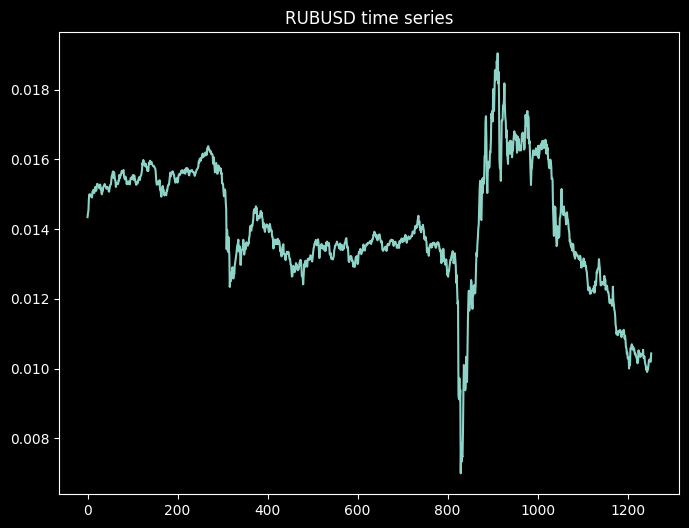

In [98]:
plt.plot(rubusdData)
plt.title("RUBUSD time series")
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.show()

The initial guesses have been set to the sample means of each regime (guessed intuitively) in the data.

In [ ]:
regime1_mean = rubusdData[0:200].mean()
regime2_mean = rubusdData[200:800].mean()
regime3_mean = 0.010
regime1_sd = rubusdData[0:200].std()
regime2_sd = rubusdData[200:800].std()
regime3_sd = rubusdData[1000:1200].std()

#### Parameter Initialisation

In [ ]:
# Initialize parameters
T = len(rubusdData)
N = 2

# SET INITIAL GUESSES

mu_hat0 = [regime1_mean, regime2_mean] * np.ones((N))
sigma_hat0 = [regime1_sd, regime2_sd] * np.ones((N))
P_hat0 = np.zeros((N, N))

P_hat0[0, 0] = 0.75
P_hat0[0, 1] = 1 - P_hat0[0, 0]
P_hat0[1, 1] = 0.7
P_hat0[1, 0] = 1 - P_hat0[1, 1]

pi_hat0 = [0.5, 0.5] * np.ones((N))
for t in range(1, 100):
    pi_hat0 = np.dot(P_hat0.T, pi_hat0)

# Determine maximum number of iterations until convergence and convergence tolerance
itemax = 200
itetol = 1e-2

#### Simulation

In [ ]:
for ite in range(0, itemax):
    print(mu_hat0, sigma_hat0, P_hat0, pi_hat0)

    # E-step
    xi_prob_t, xi_prob_t1 = forward_alg(
        pi_hat0, N, T, P_hat0, mu_hat0, sigma_hat0, rubusdData
    )
    xi_prob_T = backward_alg(
        xi_prob_t, xi_prob_t1, N, T, P_hat0, mu_hat0, sigma_hat0, rubusdData
    )

    print("")
    plt.subplot(1, 2, 1)
    plt.plot(xi_prob_T[:, 0])
    plt.subplot(1, 2, 2)
    plt.plot(xi_prob_T[:, 1])
    fig = plt.gcf()
    fig.set_size_inches(16, 6)
    plt.show()
    print("")

    # Compute Pr(s_t+1 = j, s_t = i)
    P_hat_T = np.zeros((N, N, T))
    for tt in range(1, T):
        for ss in range(0, N):
            for ss2 in range(0, N):
                P_hat_T[ss, ss2, tt] = (
                    P_hat0[ss, ss2]
                    * xi_prob_t[tt - 1, ss]
                    * xi_prob_T[tt, ss2]
                    / xi_prob_t1[tt - 1, ss2]
                )
    # M-step
    mu_hat1, sigma_hat1, P_hat1, pi_hat1 = M_step_func(xi_prob_T, P_hat_T, N, T, rubusdData)

    diff = np.zeros((4))
    diff[0] = np.sum(np.absolute(mu_hat1 - mu_hat0)) / (np.min(mu_hat0) + itetol * 1e-2)
    diff[1] = np.sum(np.absolute(sigma_hat1 - sigma_hat0)) / (
        np.min(sigma_hat0) + itetol * 1e-2
    )
    diff[2] = np.sum(np.absolute(np.subtract(P_hat1, P_hat0))) / (
        np.min(P_hat0) + itetol * 1e-2
    )
    diff[3] = np.sum(np.absolute(pi_hat1 - pi_hat0)) / (np.min(pi_hat0) + itetol * 1e-2)

    print(ite, np.max(diff))

    if np.max(diff) > itetol:
        mu_hat0, sigma_hat0, P_hat0, pi_hat0 = mu_hat1, sigma_hat1, P_hat1, pi_hat1
    else:
        # print(tabulate(
        #     [
        #         ["mu", mu_hat1, mu_hat0],
        #         ["sigma", sigma_hat1, sigma_hat0],
        #         # ["Transition matrix", P_hat1, P_hat0],
        #         # ["pi", pi_hat1, pi_hat0],
              
        #     ]
        # ))
        print(f"mu: {mu_hat1}, sigma: {sigma_hat1}, TransitionMatrix: {P_hat1}, PiHat: {pi_hat1}")
        break

## Constant Standard Deviation, Different Mean

We ahve to modify the step function to account for the fact that the standard deviation is constant. 

In [35]:
def M_step_func(xi_prob, P, N, T, Y):  #
    mu_hat = np.zeros((N))
    sigma_hat = 0
    P_hat = np.zeros((N, N))
    pi_hat = np.zeros((N))

    for ss in range(0, N):
        xi_y = np.dot(xi_prob[:, ss], Y)
        mu_hat[ss] = xi_y / np.sum(xi_prob[:, ss])

        xi_y_mu2 = np.dot(xi_prob[:, ss], (Y - mu_hat[ss]) ** 2)
        # sigma_hat[ss] = (xi_y_mu2 / np.sum(xi_prob[:, ss])) ** 0.5
        sigma_hat += xi_y_mu2

        for ss2 in range(0, N):
            P_hat[ss, ss2] = np.sum(P[ss, ss2, 1:]) / np.sum(
                P[ss, :, 1:]
            )  # /np.sum(xi_prob[0:T-1,ss]) #np.sum(P[ss,:,1:T])
            # print( np.sum(xi_prob[0:T-1,ss]), np.sum(P[ss,:,1:T]))

        pi_hat[ss] = xi_prob[0, ss]
        sigma_hat = np.sqrt(sigma_hat/T)
    return mu_hat, sigma_hat, P_hat, pi_hat


# Hamilton filtering
def forward_alg(pi_hat0, N, T, P, mu, sigma, Y):
    xi_prob_t = np.zeros((T, N))
    xi_prob_t1 = np.zeros((T, N))

    # Case t=1
    y_like = likelihood(pi_hat0, mu, sigma, Y[0])
    for ss in range(0, N):
        phi = np.zeros((N))
        for ss2 in range(0, N):
            phi[ss2] = norm.pdf((Y[0] - mu[ss2]) / sigma)
    xi_prob_t[0, :] = np.multiply(pi_hat0, phi) / y_like
    for ss in range(0, N):
        xi_prob_t1[0, ss] = np.dot(P[:, ss], xi_prob_t[0, :])

    for tt in range(1, T):
        y_like = likelihood(xi_prob_t1[tt - 1, :], mu, sigma, Y[tt])
        for ss in range(0, N):
            phi = np.zeros((N))
            for ss2 in range(0, N):
                phi[ss2] = norm.pdf((Y[tt] - mu[ss2]) / sigma)
        xi_prob_t[tt, :] = np.multiply(xi_prob_t1[tt - 1, :], phi) / y_like
        for ss in range(0, N):
            xi_prob_t1[tt, ss] = np.dot(P[:, ss], xi_prob_t[tt, :])

    return xi_prob_t, xi_prob_t1

In [36]:
# Initialize parameters
T = len(rubusdData)
N = 2

# SET INITIAL GUESSES

mu_hat0 = [regime1_mean, regime2_mean] * np.ones((N))
sigma_hat0 = rubusdData.std()
P_hat0 = np.zeros((N, N))

P_hat0[0, 0] = 0.75
P_hat0[0, 1] = 1 - P_hat0[0, 0]
P_hat0[1, 1] = 0.7
P_hat0[1, 0] = 1 - P_hat0[1, 1]

pi_hat0 = [0.5, 0.5] * np.ones((N))
for t in range(1, 100):
    pi_hat0 = np.dot(P_hat0.T, pi_hat0)

# Determine maximum number of iterations until convergence and convergence tolerance
itemax = 200
itetol = 1e-2

[0.01538115 0.01392338], sigma: 0.0017584997738856812, [[0.75 0.25]
 [0.3  0.7 ]], [0.54545455 0.45454545]


C:\Users\kumar\AppData\Local\Temp\ipykernel_29592\3953164602.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi[ss2] = norm.pdf((Y[0] - mu[ss2]) / sigma)
C:\Users\kumar\AppData\Local\Temp\ipykernel_29592\3953164602.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi[ss2] = norm.pdf((Y[tt] - mu[ss2]) / sigma)


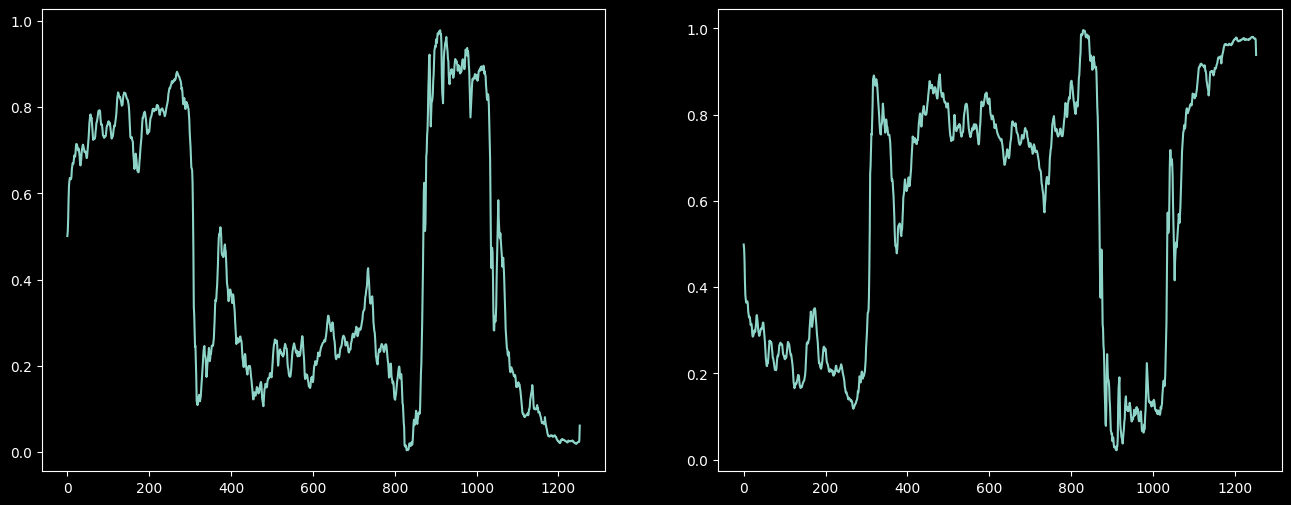


0 1.3485127001139416
[0.01521462 0.01317359], sigma: [0.00142487], [[0.7816801  0.2183199 ]
 [0.16304859 0.83695141]], [0.50116736 0.49883264]


C:\Users\kumar\AppData\Local\Temp\ipykernel_29592\3953164602.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mu_hat[ss] = xi_y / np.sum(xi_prob[:, ss])


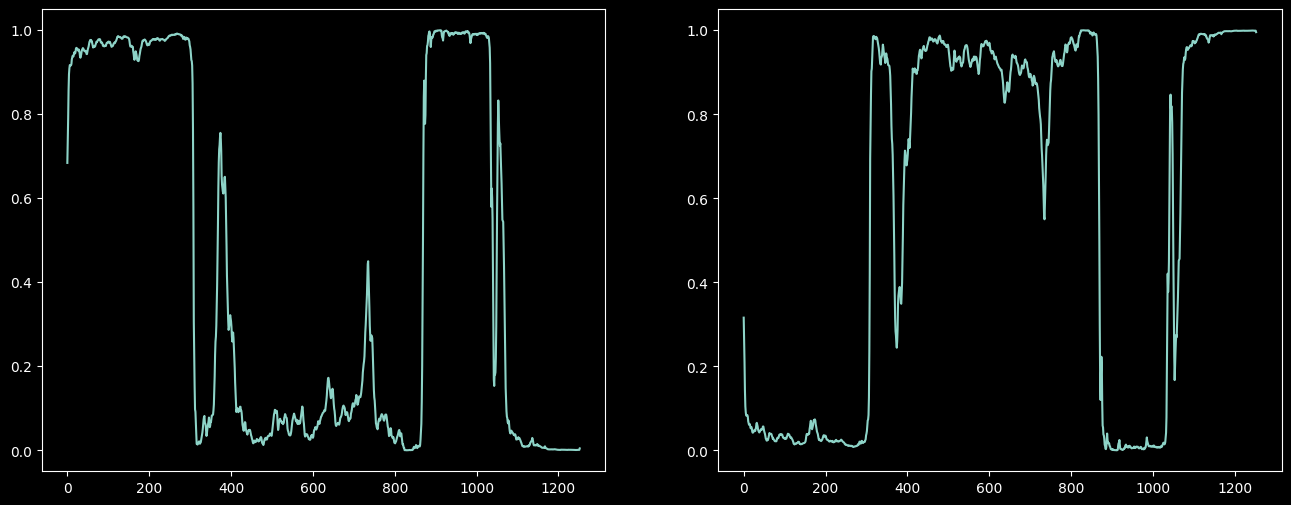


1 3.190550501556075
[0.01556823 0.01289025], sigma: [0.00119765], [[0.93072854 0.06927146]
 [0.05183013 0.94816987]], [0.68392782 0.31607218]



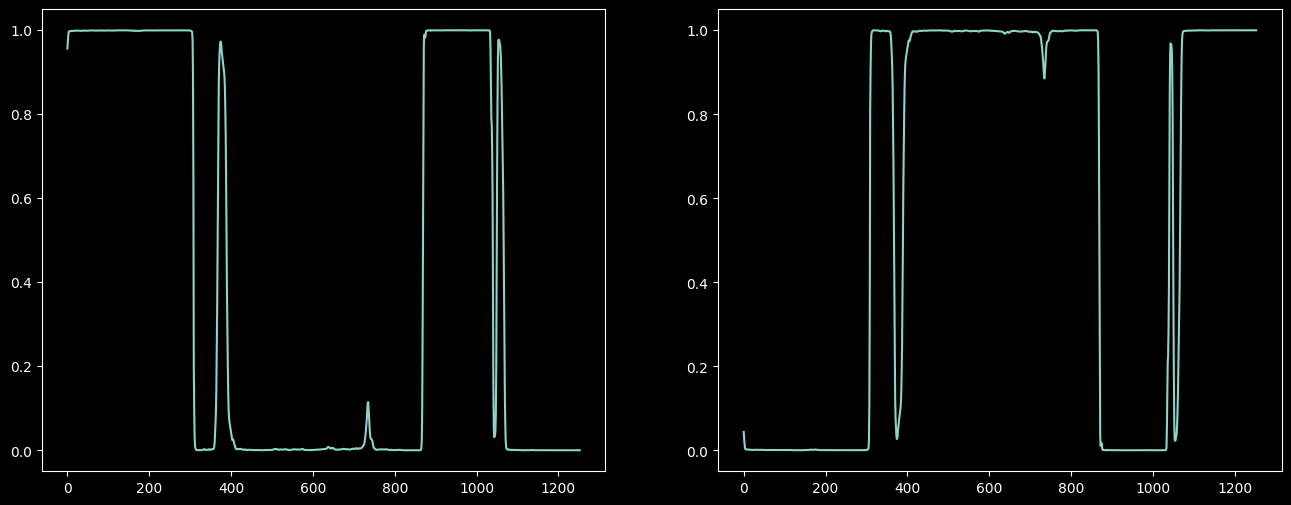


2 4.0047407142476885
[0.0157105  0.01287337], sigma: [0.00113312], [[0.98920765 0.01079235]
 [0.00632589 0.99367411]], [0.95648487 0.04351513]



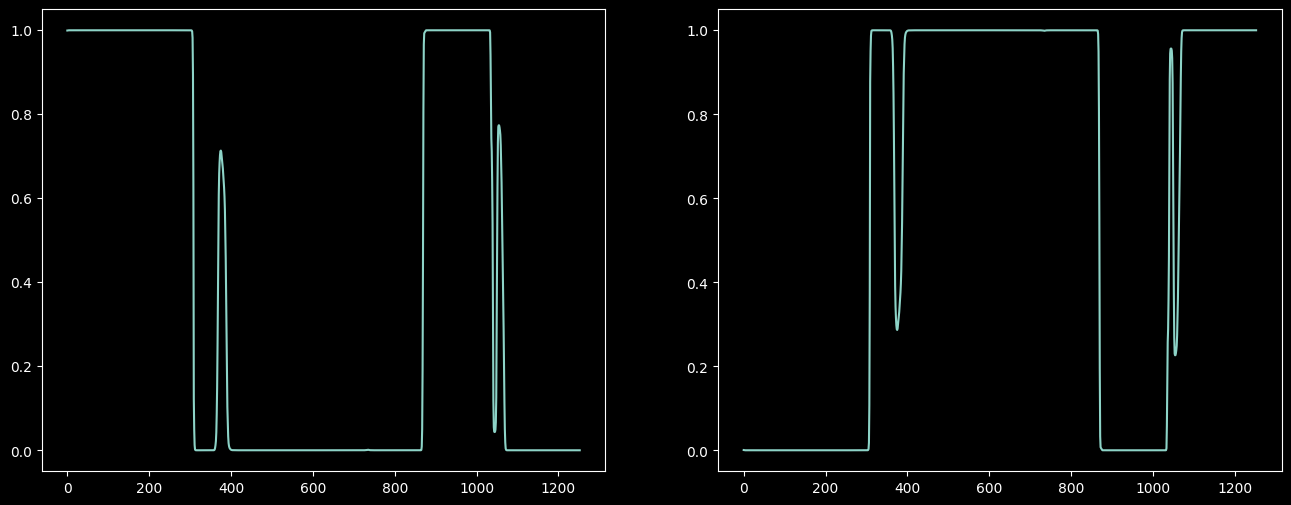


3 2.130533465127396
[0.0157523 0.0129008], sigma: [0.00113455], [[0.99306318 0.00693682]
 [0.00333613 0.99666387]], [9.99416190e-01 5.83809655e-04]



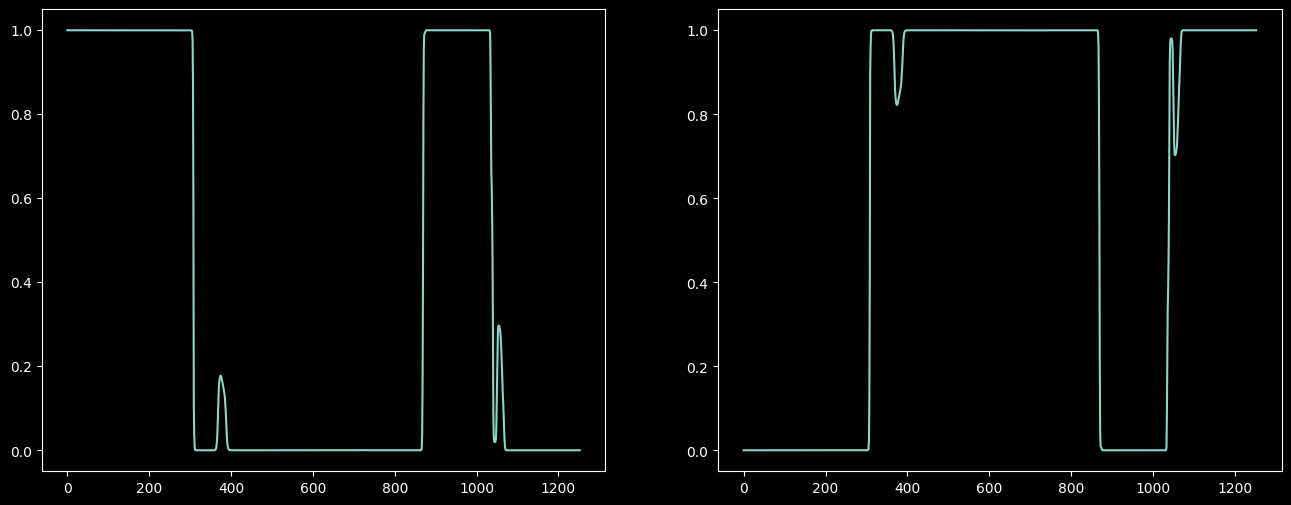


4 1.8802244034264135
[0.01580447 0.01293906], sigma: [0.00113994], [[0.99488513 0.00511487]
 [0.00192773 0.99807227]], [9.99995443e-01 4.55707274e-06]



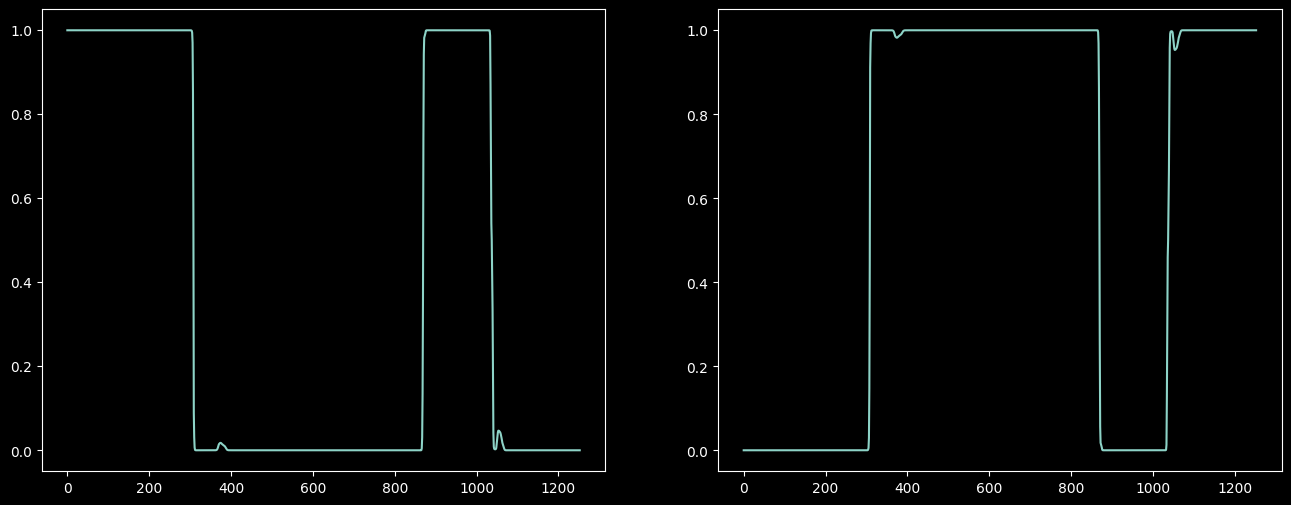


5 1.3079446592263175
[0.01582617 0.01295377], sigma: [0.00114156], [[0.99566315 0.00433685]
 [0.00137967 0.99862033]], [9.99999975e-01 2.51291150e-08]



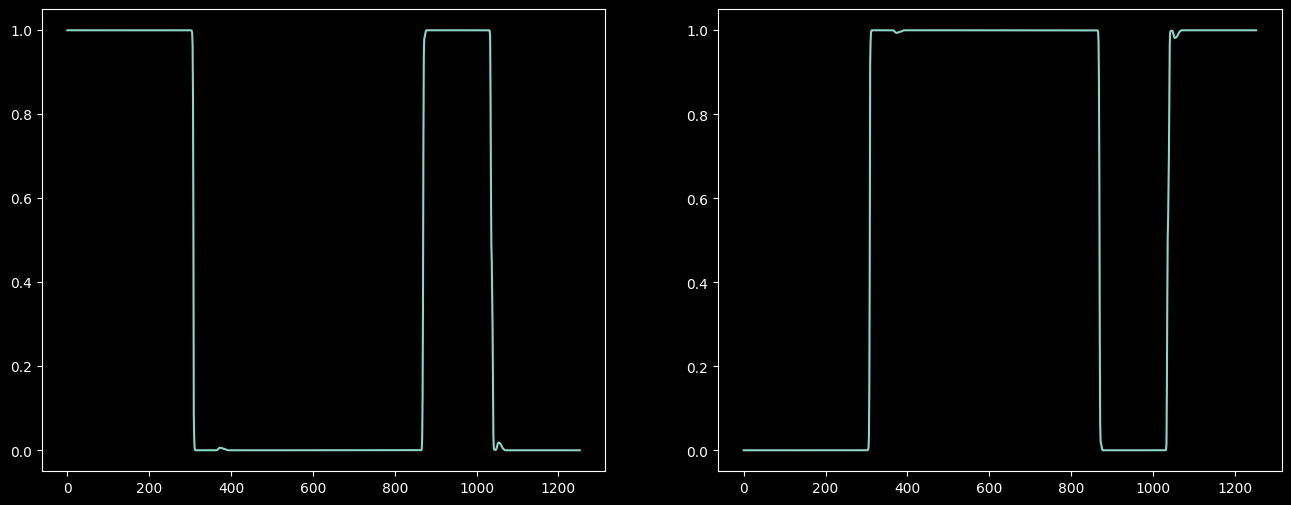


6 0.18258064161237797
[0.01582895 0.01295558], sigma: [0.00114173], [[0.99574252 0.00425748]
 [0.00132396 0.99867604]], [1.00000000e+00 1.07811554e-10]



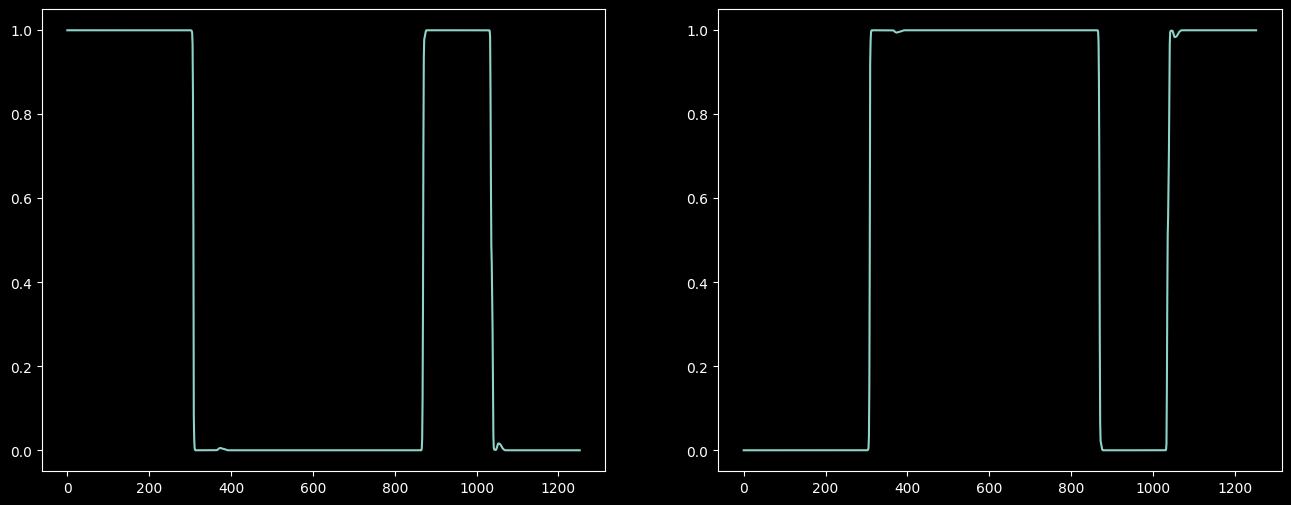


7 0.01288607100287283
[0.0158292  0.01295575], sigma: [0.00114174], [[0.99574782 0.00425218]
 [0.00132008 0.99867992]], [1.00000000e+00 4.48622907e-13]



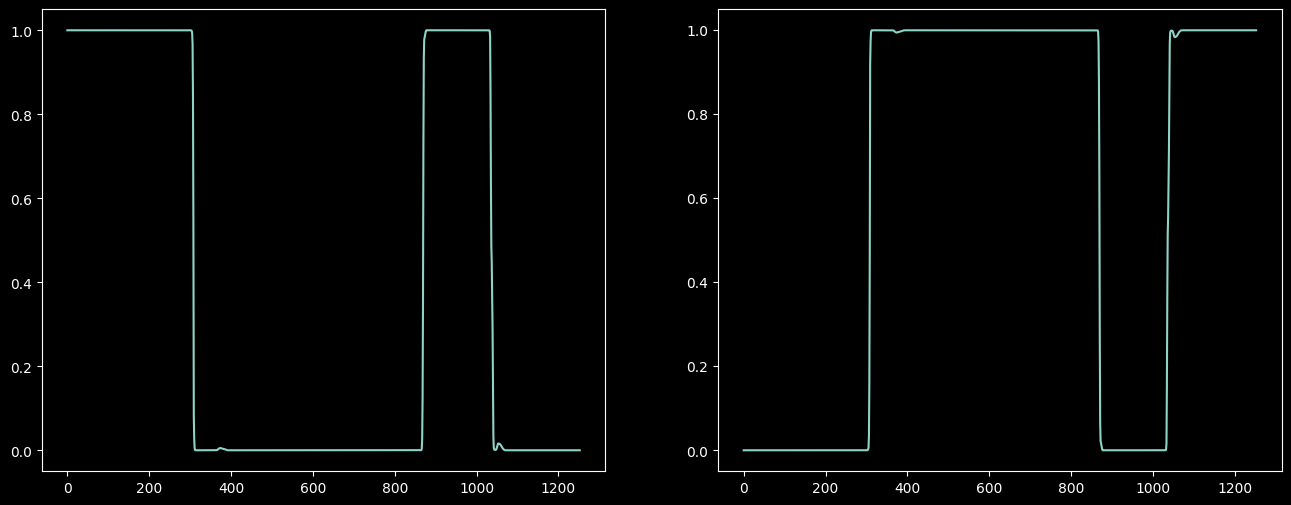


8 0.0009572696177532408
mu: [0.01582922 0.01295576], sigma: [0.00114174], TransitionMatrix: [[0.99574821 0.00425179]
 [0.00131979 0.99868021]], PiHat: [1.00000000e+00 1.86314307e-15]


In [37]:
for ite in range(0, itemax):
    print(f"{mu_hat0}, sigma: {sigma_hat0}, {P_hat0}, {pi_hat0}")

    # E-step
    xi_prob_t, xi_prob_t1 = forward_alg(
        pi_hat0, N, T, P_hat0, mu_hat0, sigma_hat0, rubusdData
    )
    xi_prob_T = backward_alg(
        xi_prob_t, xi_prob_t1, N, T, P_hat0, mu_hat0, sigma_hat0, rubusdData
    )

    print("")
    plt.subplot(1, 2, 1)
    plt.plot(xi_prob_T[:, 0])
    plt.subplot(1, 2, 2)
    plt.plot(xi_prob_T[:, 1])
    fig = plt.gcf()
    fig.set_size_inches(16, 6)
    plt.show()
    print("")

    # Compute Pr(s_t+1 = j, s_t = i)
    P_hat_T = np.zeros((N, N, T))
    for tt in range(1, T):
        for ss in range(0, N):
            for ss2 in range(0, N):
                P_hat_T[ss, ss2, tt] = (
                    P_hat0[ss, ss2]
                    * xi_prob_t[tt - 1, ss]
                    * xi_prob_T[tt, ss2]
                    / xi_prob_t1[tt - 1, ss2]
                )
    # M-step
    mu_hat1, sigma_hat1, P_hat1, pi_hat1 = M_step_func(xi_prob_T, P_hat_T, N, T, rubusdData)

    diff = np.zeros((4))
    diff[0] = np.sum(np.absolute(mu_hat1 - mu_hat0)) / (np.min(mu_hat0) + itetol * 1e-2)
    diff[1] = np.sum(np.absolute(sigma_hat1 - sigma_hat0)) / (
        np.min(sigma_hat0) + itetol * 1e-2
    )
    diff[2] = np.sum(np.absolute(np.subtract(P_hat1, P_hat0))) / (
        np.min(P_hat0) + itetol * 1e-2
    )
    diff[3] = np.sum(np.absolute(pi_hat1 - pi_hat0)) / (np.min(pi_hat0) + itetol * 1e-2)

    print(ite, np.max(diff))

    if np.max(diff) > itetol:
        mu_hat0, sigma_hat0, P_hat0, pi_hat0 = mu_hat1, sigma_hat1, P_hat1, pi_hat1
    else:
        # print(tabulate(
        #     [
        #         ["mu", mu_hat1, mu_hat0],
        #         ["sigma", sigma_hat1, sigma_hat0],
        #         # ["Transition matrix", P_hat1, P_hat0],
        #         # ["pi", pi_hat1, pi_hat0],
              
        #     ]
        # ))
        print(f"mu: {mu_hat1}, sigma: {sigma_hat1}, TransitionMatrix: {P_hat1}, PiHat: {pi_hat1}")
        break

## Different Standard Deviation, Constant Mean

In [90]:
# Initialize parameters
T = len(rubusdData)
N = 2

# SET INITIAL GUESSES

mu_hat0 = rubusdData.mean()
sigma_hat0 = [regime1_sd, regime2_sd] * np.ones((N))
P_hat0 = np.zeros((N, N))

P_hat0[0, 0] = 0.75
P_hat0[0, 1] = 1 - P_hat0[0, 0]
P_hat0[1, 1] = 0.7
P_hat0[1, 0] = 1 - P_hat0[1, 1]

pi_hat0 = [0.5, 0.5] * np.ones((N))
for t in range(1, 100):
    pi_hat0 = np.dot(P_hat0.T, pi_hat0)

# Determine maximum number of iterations until convergence and convergence tolerance
itemax = 200
itetol = 1e-2

In [91]:
print(P_hat0)

[[0.75 0.25]
 [0.3  0.7 ]]


#### Modification applied to the functions to account for the fact that the standard deviation is constant and mean is different

In [92]:
def M_step_func(xi_prob, sigma_hat_prev, P, N, T, Y):  #
    sigma_hat = np.zeros((N))
    P_hat = np.zeros((N, N))
    pi_hat = np.zeros((N))
    
    xi_y_sigma = np.zeros_like((N))
    xi_sigma = np.zeros((N))
    for ss in range(0, N):
        xi_y_sigma = np.dot(xi_prob[:, ss], Y) / sigma_hat_prev[ss]
        xi_sigma[ss] = np.sum(xi_prob[:, ss]) / sigma_hat_prev[ss]
    mu_hat = np.sum(xi_y_sigma) / np.sum(xi_sigma)

    for ss in range(0, N):
        xi_y_mu2 = np.dot(xi_prob[:, ss], (Y - mu_hat) ** 2)
        sigma_hat[ss] = (xi_y_mu2 / np.sum(xi_prob[:, ss])) ** 0.5

        for ss2 in range(0,N):
              P_hat[ss, ss2] = np.sum(P[ss, ss2, 1:]) / np.sum(
                P[ss, :, 1:]
            )  
        pi_hat[ss] = xi_prob[0, ss]
    return mu_hat, sigma_hat, P_hat, pi_hat

def forward_alg(pi_hat0, N, T, P, mu, sigma, Y):
    xi_prob_t = np.zeros((T, N))
    xi_prob_t1 = np.zeros((T, N))

    # Case t=1
    y_like = likelihood(pi_hat0, mu, sigma, Y[0])
    for ss in range(0, N):
        phi = np.zeros((N))
        for ss2 in range(0, N):
            phi[ss2] = norm.pdf((Y[0] - mu) / sigma[ss2])
    xi_prob_t[0, :] = np.multiply(pi_hat0, phi) / y_like
    for ss in range(0, N):
  
        print(P)
        xi_prob_t1[0, ss] = np.dot(P[:, ss], xi_prob_t[0, :])

    for tt in range(1, T):
        y_like = likelihood(xi_prob_t1[tt - 1, :], mu, sigma, Y[tt])
        for ss in range(0, N):
            phi = np.zeros((N))
            for ss2 in range(0, N):
                phi[ss2] = norm.pdf((Y[tt] - mu) / sigma[ss2])
        xi_prob_t[tt, :] = np.multiply(xi_prob_t1[tt - 1, :], phi) / y_like
        for ss in range(0, N):
            xi_prob_t1[tt, ss] = np.dot(P[:, ss], xi_prob_t[tt, :])

    return xi_prob_t, xi_prob_t1

### Simulation

mu: 0.014047481245011973, sigma: [0.00028508 0.00094661], phat0: [[0.75 0.25]
 [0.3  0.7 ]], [0.54545455 0.45454545]
[[0.75 0.25]
 [0.3  0.7 ]]
[[0.75 0.25]
 [0.3  0.7 ]]


C:\Users\kumar\AppData\Local\Temp\ipykernel_29592\3073733198.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi[ss2] = norm.pdf((Y[0] - mu) / sigma[ss2])
C:\Users\kumar\AppData\Local\Temp\ipykernel_29592\3073733198.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi[ss2] = norm.pdf((Y[tt] - mu) / sigma[ss2])


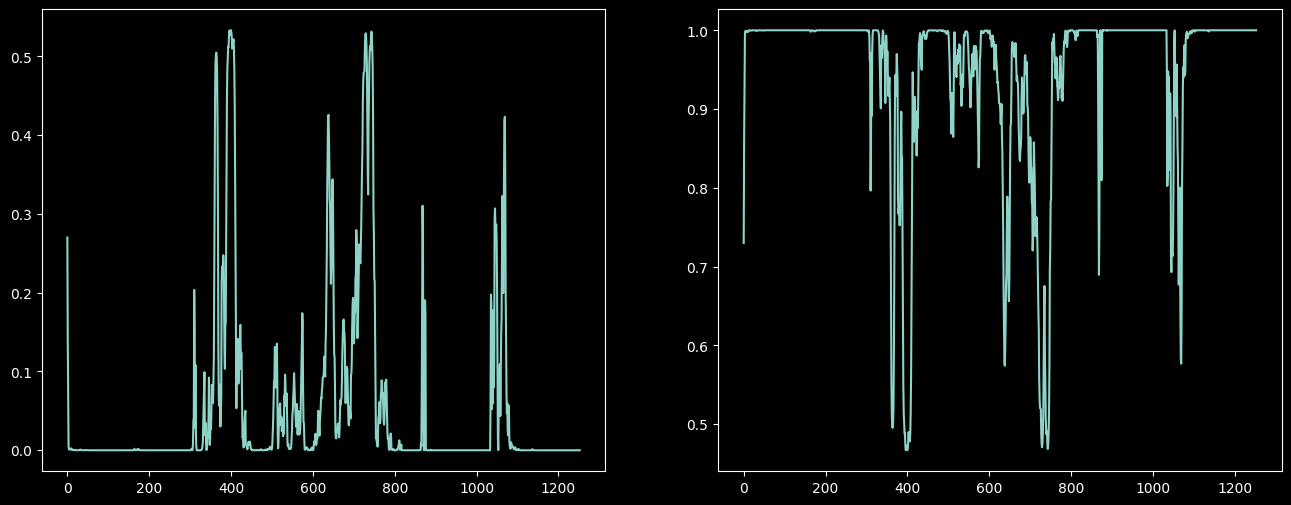


0 9.779784389056813
mu: 0.011814773254755426, sigma: [0.00211984 0.00287783], phat0: [[0.54353182 0.45646818]
 [0.02585862 0.97414138]], [0.27003779 0.72996221]
[[0.54353182 0.45646818]
 [0.02585862 0.97414138]]
[[0.54353182 0.45646818]
 [0.02585862 0.97414138]]


C:\Users\kumar\AppData\Local\Temp\ipykernel_29592\3073733198.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma_hat[ss] = (xi_y_mu2 / np.sum(xi_prob[:, ss])) ** 0.5


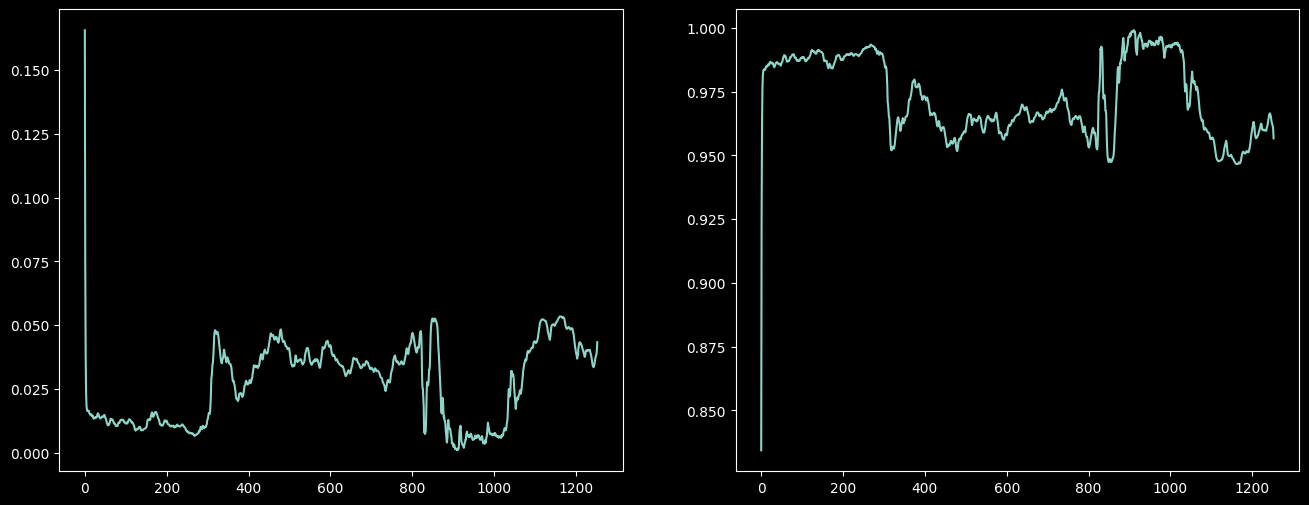


1 7.707247334242737
mu: 0.01355269049449926, sigma: [0.00144648 0.00183633], phat0: [[0.45413119 0.54586881]
 [0.01522448 0.98477552]], [0.1656302 0.8343698]
[[0.45413119 0.54586881]
 [0.01522448 0.98477552]]
[[0.45413119 0.54586881]
 [0.01522448 0.98477552]]



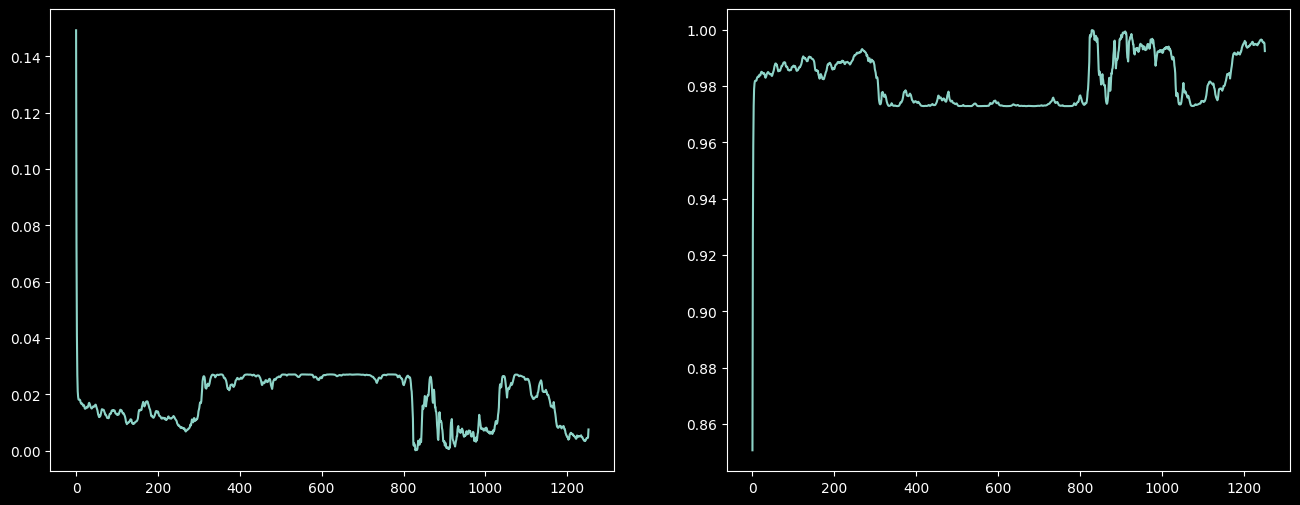


2 6.745536970629665
mu: 0.013725749959937528, sigma: [0.00117029 0.00179721], phat0: [[0.40669442 0.59330558]
 [0.01097532 0.98902468]], [0.14928655 0.85071345]
[[0.40669442 0.59330558]
 [0.01097532 0.98902468]]
[[0.40669442 0.59330558]
 [0.01097532 0.98902468]]



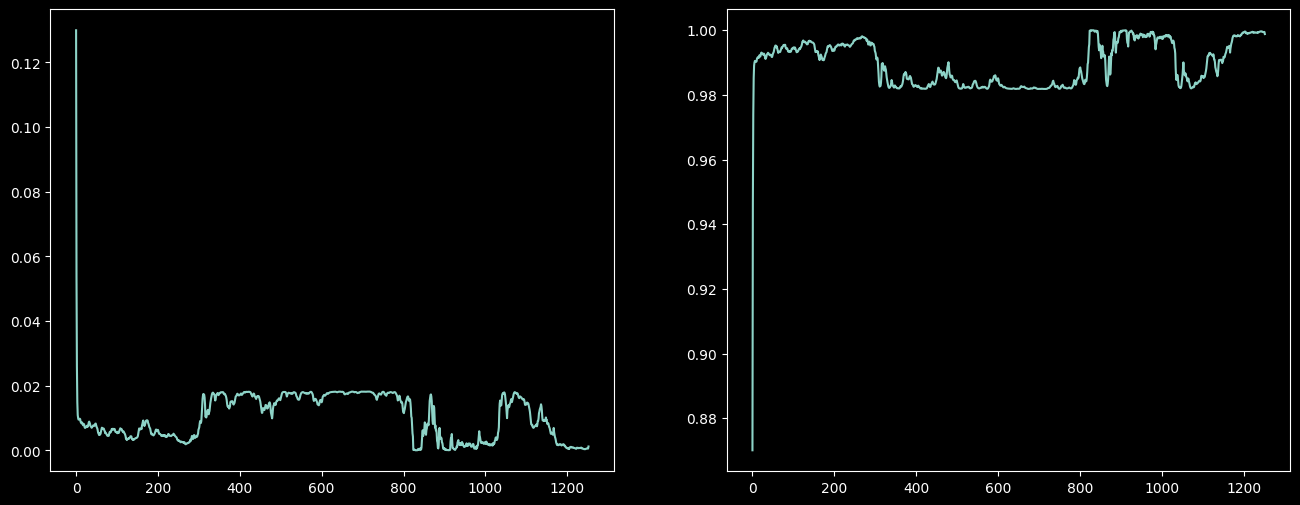


3 10.617060603294949
mu: 0.013830347254776406, sigma: [0.00092551 0.00177851], phat0: [[0.35227468 0.64772532]
 [0.0066014  0.9933986 ]], [0.1299289 0.8700711]
[[0.35227468 0.64772532]
 [0.0066014  0.9933986 ]]
[[0.35227468 0.64772532]
 [0.0066014  0.9933986 ]]



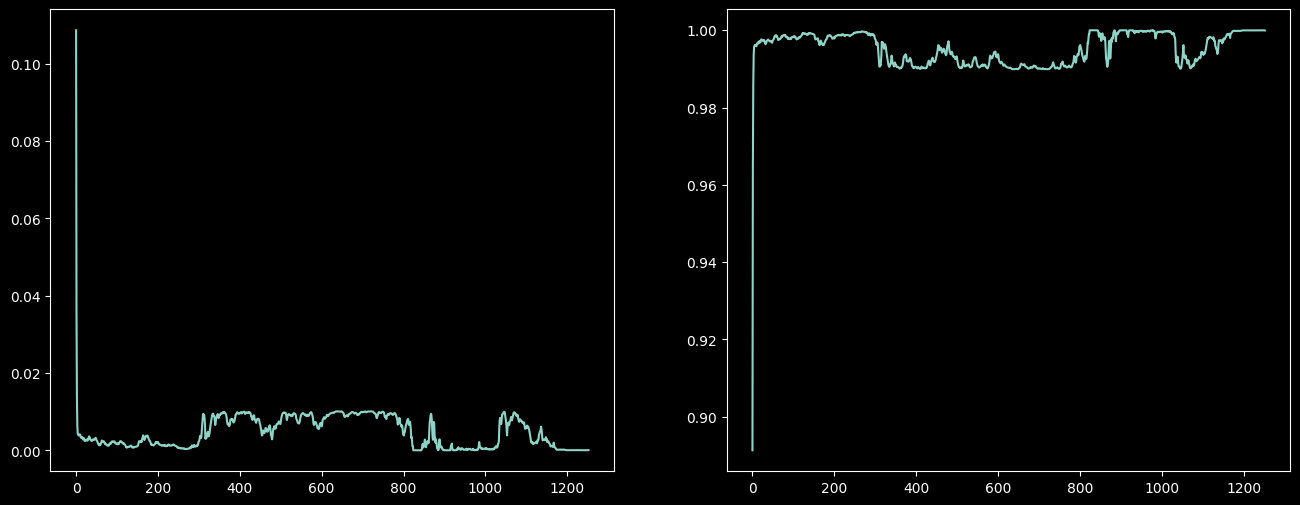


4 18.30615293941918
mu: 0.013921989090717332, sigma: [0.00075104 0.00176639], phat0: [[0.29427608 0.70572392]
 [0.00326154 0.99673846]], [0.10866298 0.89133702]
[[0.29427608 0.70572392]
 [0.00326154 0.99673846]]
[[0.29427608 0.70572392]
 [0.00326154 0.99673846]]



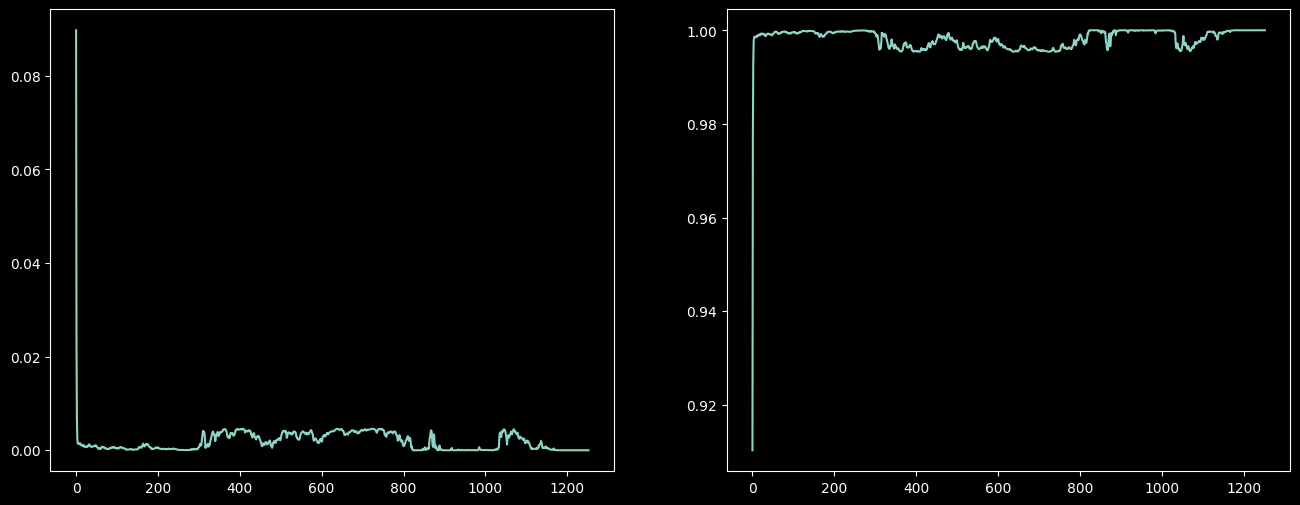


5 37.26684239775217
mu: 0.013987622482101964, sigma: [0.00065007 0.00176091], phat0: [[0.23356523 0.76643477]
 [0.00133541 0.99866459]], [0.08969752 0.91030248]
[[0.23356523 0.76643477]
 [0.00133541 0.99866459]]
[[0.23356523 0.76643477]
 [0.00133541 0.99866459]]



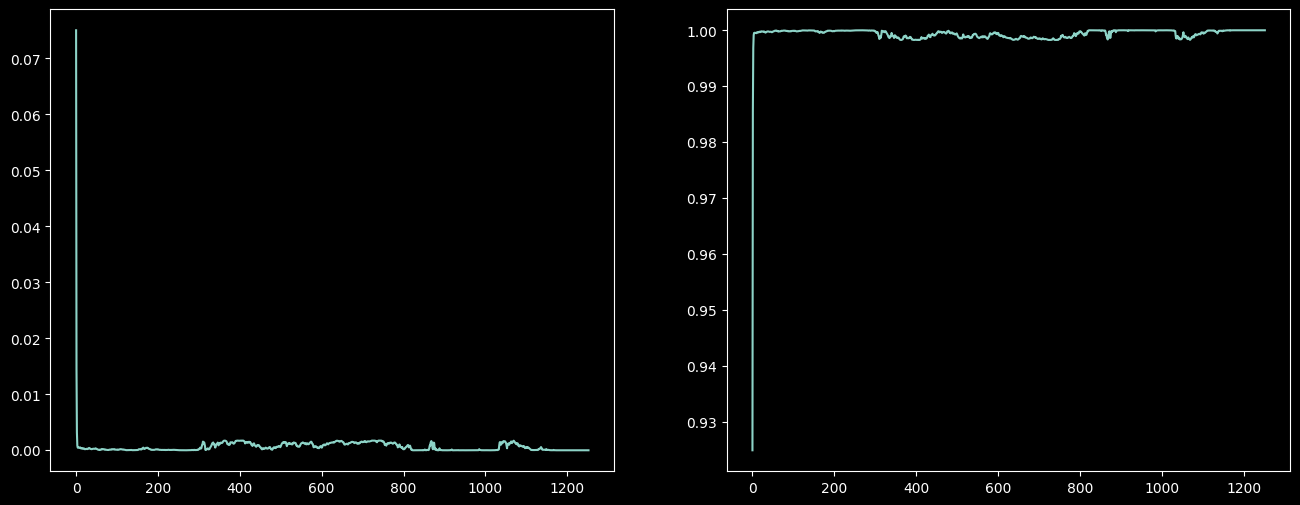


6 81.85347941586794
mu: 0.01402310990689346, sigma: [0.00058825 0.00175917], phat0: [[1.75681761e-01 8.24318239e-01]
 [4.72302715e-04 9.99527697e-01]], [0.07500652 0.92499348]
[[1.75681761e-01 8.24318239e-01]
 [4.72302715e-04 9.99527697e-01]]
[[1.75681761e-01 8.24318239e-01]
 [4.72302715e-04 9.99527697e-01]]



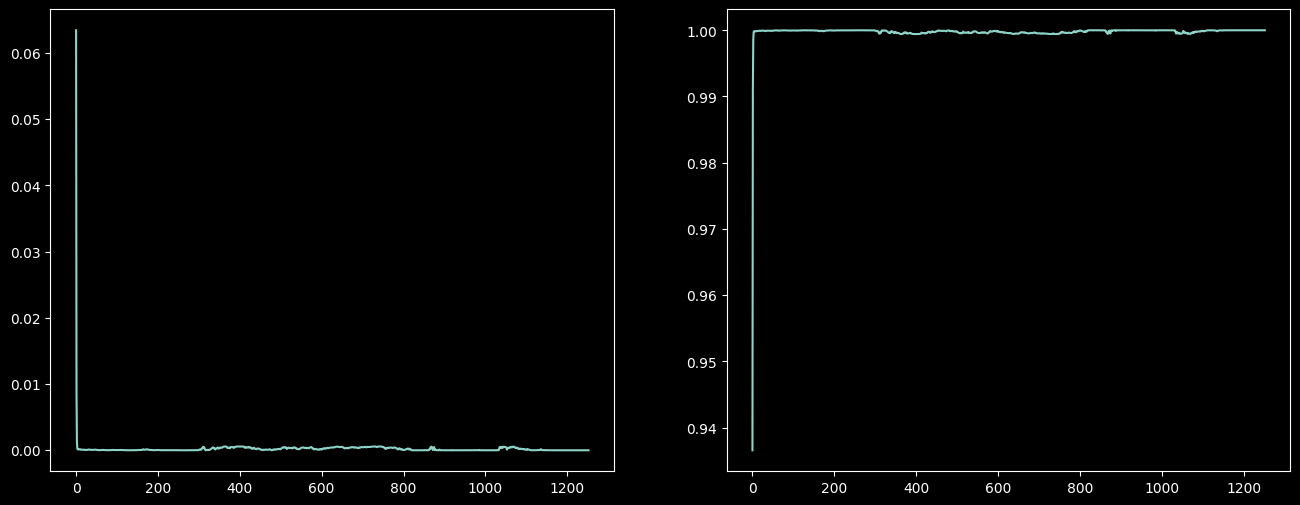


7 168.82424702921236
mu: 0.014037836627778768, sigma: [0.00052703 0.00175871], phat0: [[1.27694332e-01 8.72305668e-01]
 [1.50444167e-04 9.99849556e-01]], [0.06343614 0.93656386]
[[1.27694332e-01 8.72305668e-01]
 [1.50444167e-04 9.99849556e-01]]
[[1.27694332e-01 8.72305668e-01]
 [1.50444167e-04 9.99849556e-01]]



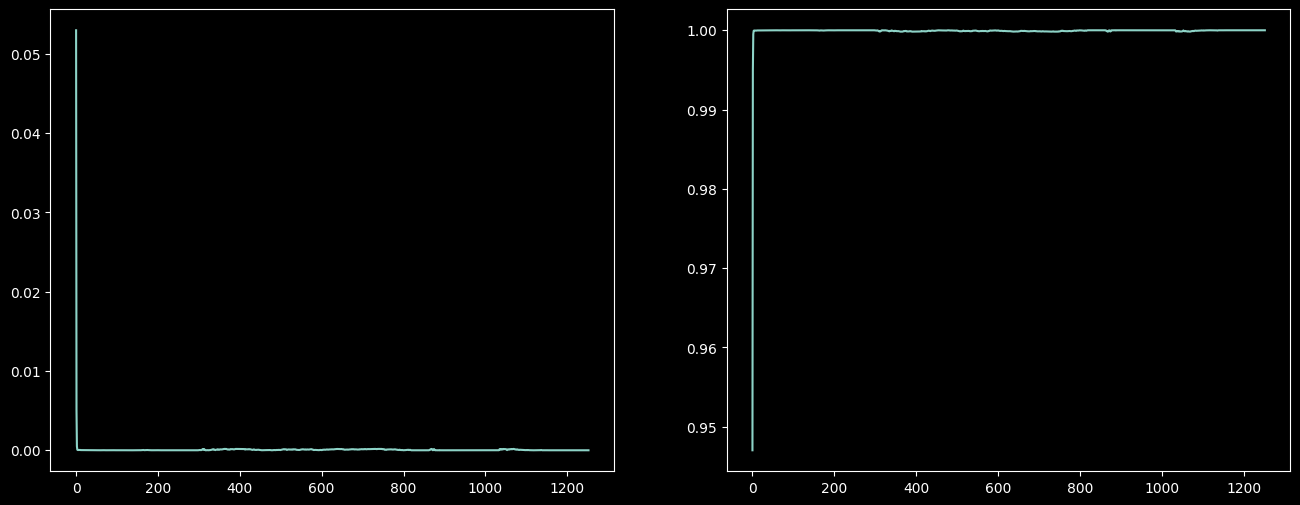


8 298.17028213169925
mu: 0.014043099977016674, sigma: [0.00043997 0.00175858], phat0: [[9.04645345e-02 9.09535465e-01]
 [4.27375618e-05 9.99957262e-01]], [0.0529806 0.9470194]
[[9.04645345e-02 9.09535465e-01]
 [4.27375618e-05 9.99957262e-01]]
[[9.04645345e-02 9.09535465e-01]
 [4.27375618e-05 9.99957262e-01]]



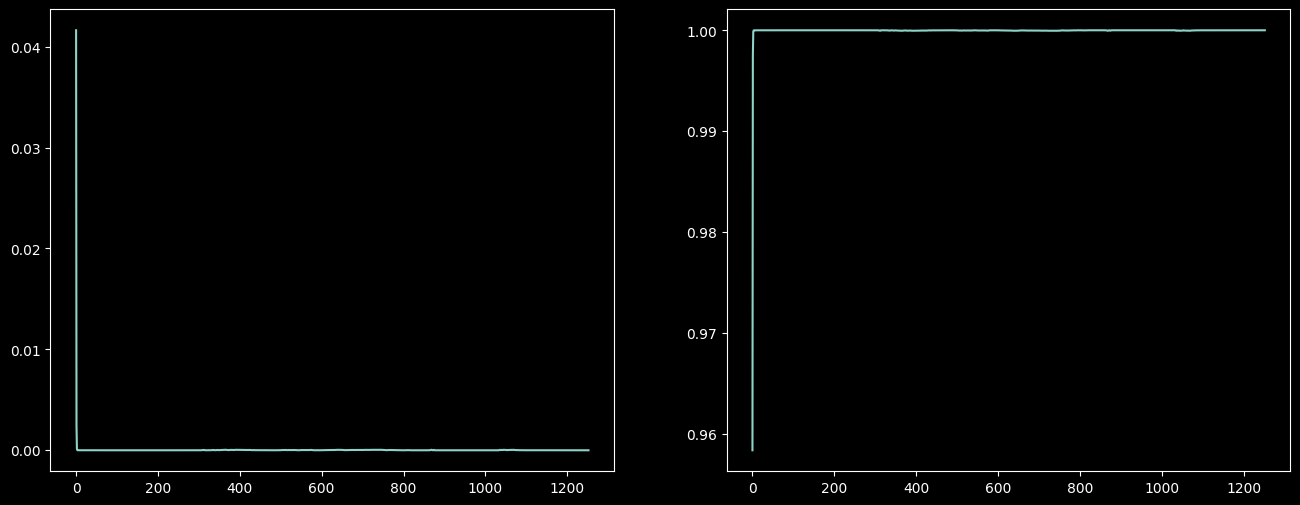


9 448.76189687624804
mu: 0.014044899862804066, sigma: [0.00035006 0.00175854], phat0: [[5.84697322e-02 9.41530268e-01]
 [9.95043857e-06 9.99990050e-01]], [0.04161705 0.95838295]
[[5.84697322e-02 9.41530268e-01]
 [9.95043857e-06 9.99990050e-01]]
[[5.84697322e-02 9.41530268e-01]
 [9.95043857e-06 9.99990050e-01]]



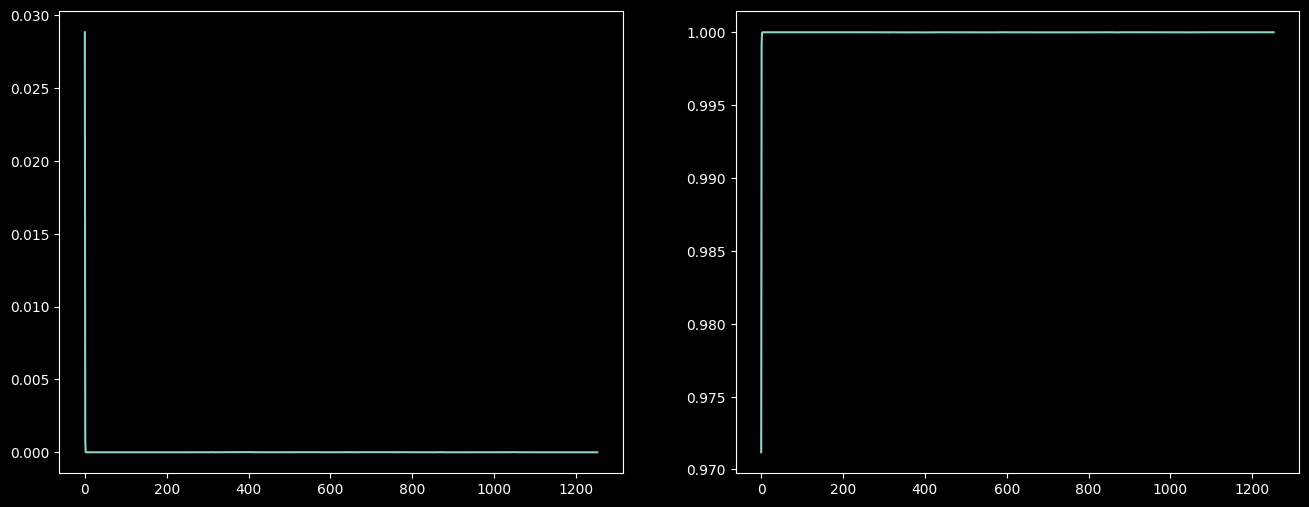


10 520.1978103921228
mu: 0.014045673163457829, sigma: [0.00030954 0.00175852], phat0: [[2.98799269e-02 9.70120073e-01]
 [1.76704958e-06 9.99998233e-01]], [0.02881975 0.97118025]
[[2.98799269e-02 9.70120073e-01]
 [1.76704958e-06 9.99998233e-01]]
[[2.98799269e-02 9.70120073e-01]
 [1.76704958e-06 9.99998233e-01]]



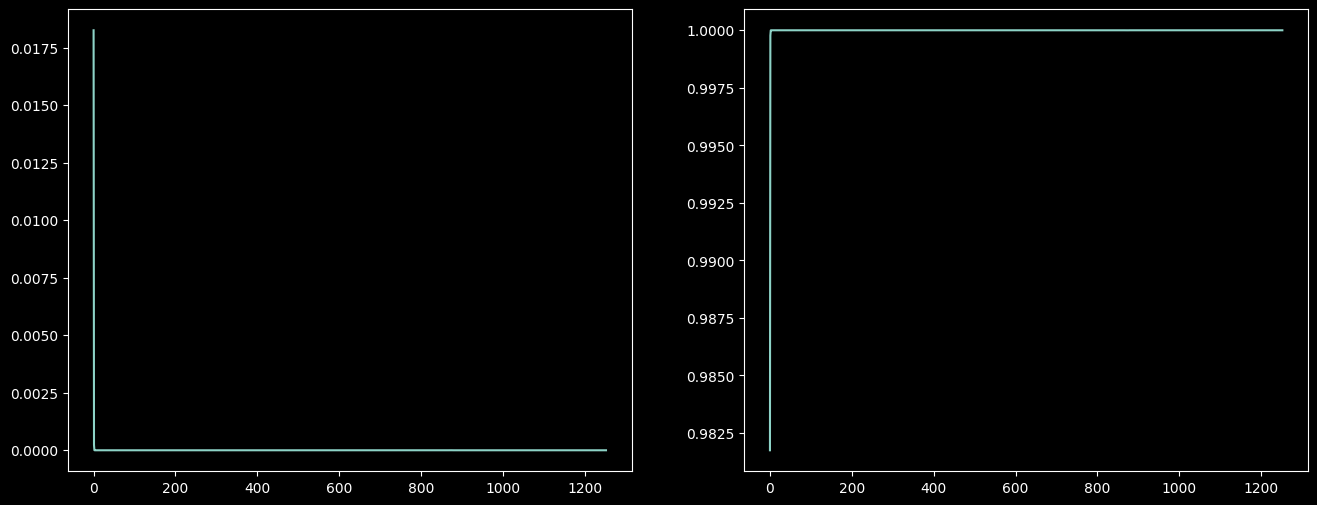


11 339.7019471161674
mu: 0.014046278039729142, sigma: [0.00030059 0.00175851], phat0: [[1.25961917e-02 9.87403808e-01]
 [2.69777035e-07 9.99999730e-01]], [0.01824937 0.98175063]
[[1.25961917e-02 9.87403808e-01]
 [2.69777035e-07 9.99999730e-01]]
[[1.25961917e-02 9.87403808e-01]
 [2.69777035e-07 9.99999730e-01]]



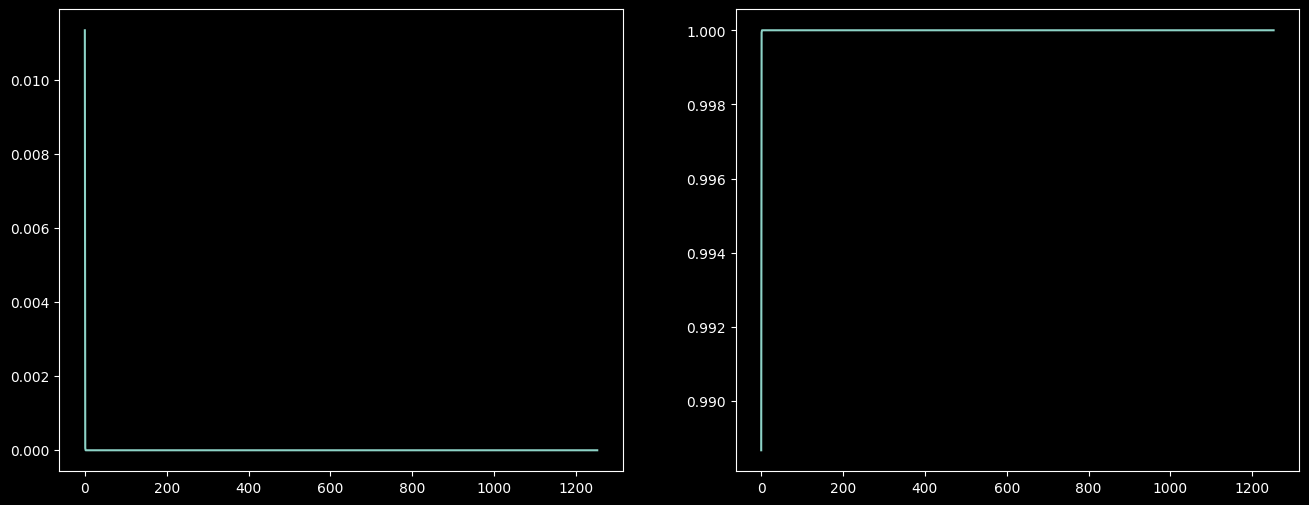


12 150.73509392730858
mu: 0.014046728506231471, sigma: [0.00029821 0.00175851], phat0: [[5.03933451e-03 9.94960665e-01]
 [3.98276897e-08 9.99999960e-01]], [0.01132878 0.98867122]
[[5.03933451e-03 9.94960665e-01]
 [3.98276897e-08 9.99999960e-01]]
[[5.03933451e-03 9.94960665e-01]
 [3.98276897e-08 9.99999960e-01]]



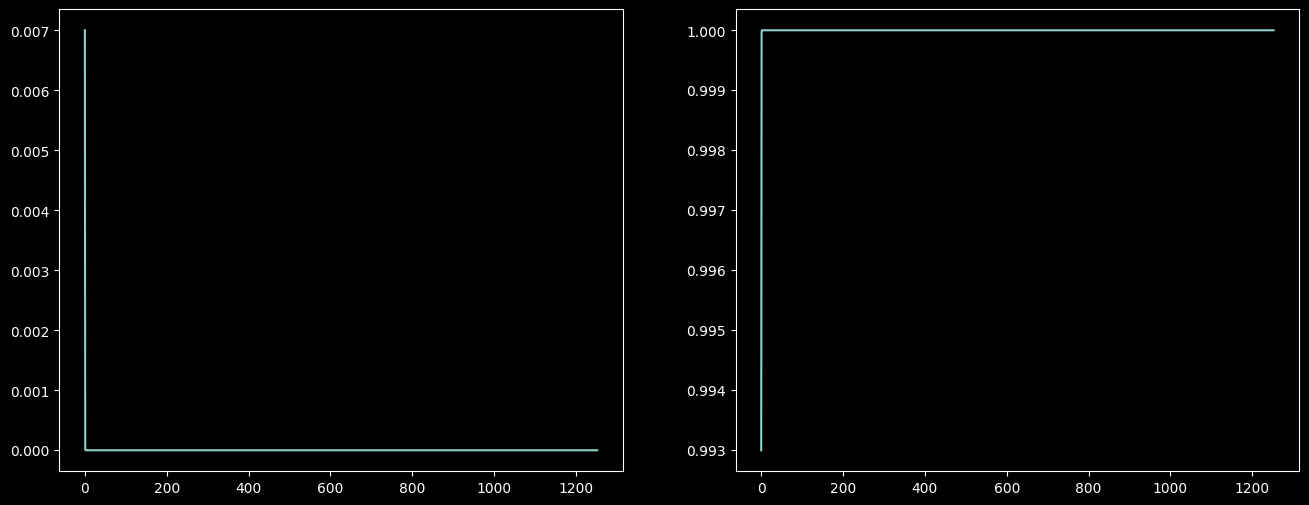


13 60.952416017896596
mu: 0.014047015337080476, sigma: [0.00029732 0.0017585 ], phat0: [[1.99053391e-03 9.98009466e-01]
 [5.82997335e-09 9.99999994e-01]], [0.00700125 0.99299875]
[[1.99053391e-03 9.98009466e-01]
 [5.82997335e-09 9.99999994e-01]]
[[1.99053391e-03 9.98009466e-01]
 [5.82997335e-09 9.99999994e-01]]



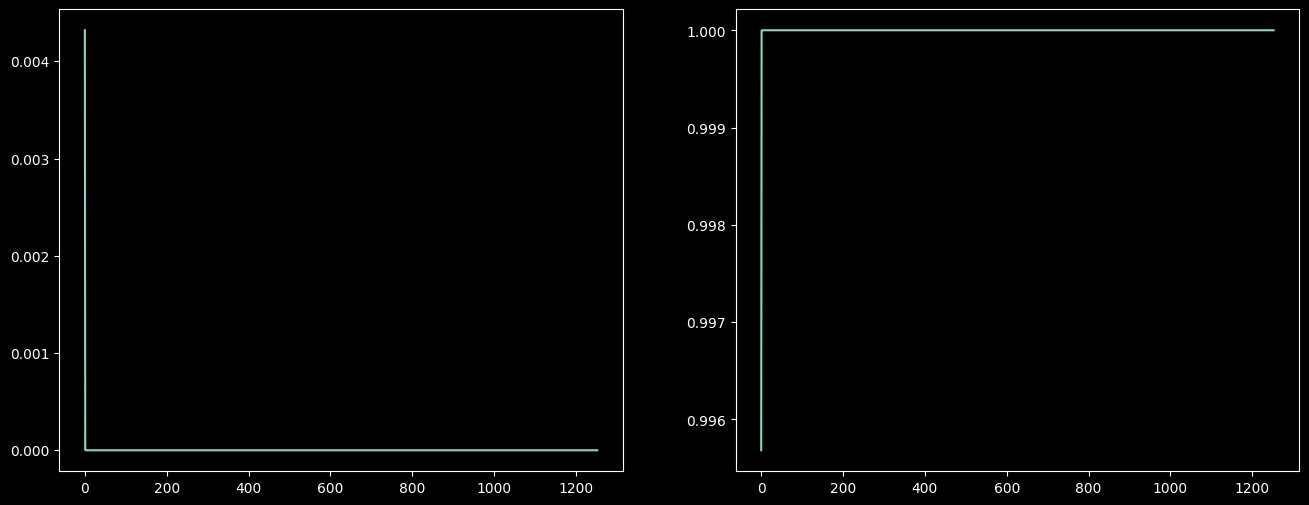


14 24.148557873974383
mu: 0.014047193563858598, sigma: [0.00029693 0.0017585 ], phat0: [[7.83040607e-04 9.99216959e-01]
 [8.50503342e-10 9.99999999e-01]], [0.00431868 0.99568132]
[[7.83040607e-04 9.99216959e-01]
 [8.50503342e-10 9.99999999e-01]]
[[7.83040607e-04 9.99216959e-01]
 [8.50503342e-10 9.99999999e-01]]



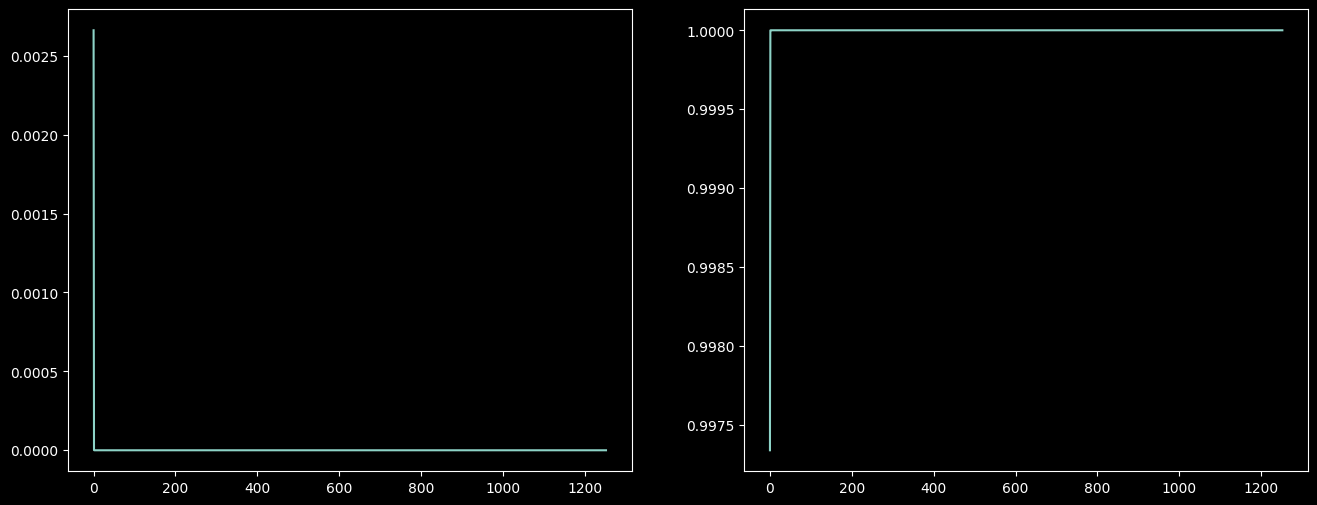


15 9.50930509974244
mu: 0.01404730385766298, sigma: [0.00029674 0.0017585 ], phat0: [[3.07572035e-04 9.99692428e-01]
 [1.23873199e-10 1.00000000e+00]], [0.00266123 0.99733877]
[[3.07572035e-04 9.99692428e-01]
 [1.23873199e-10 1.00000000e+00]]
[[3.07572035e-04 9.99692428e-01]
 [1.23873199e-10 1.00000000e+00]]



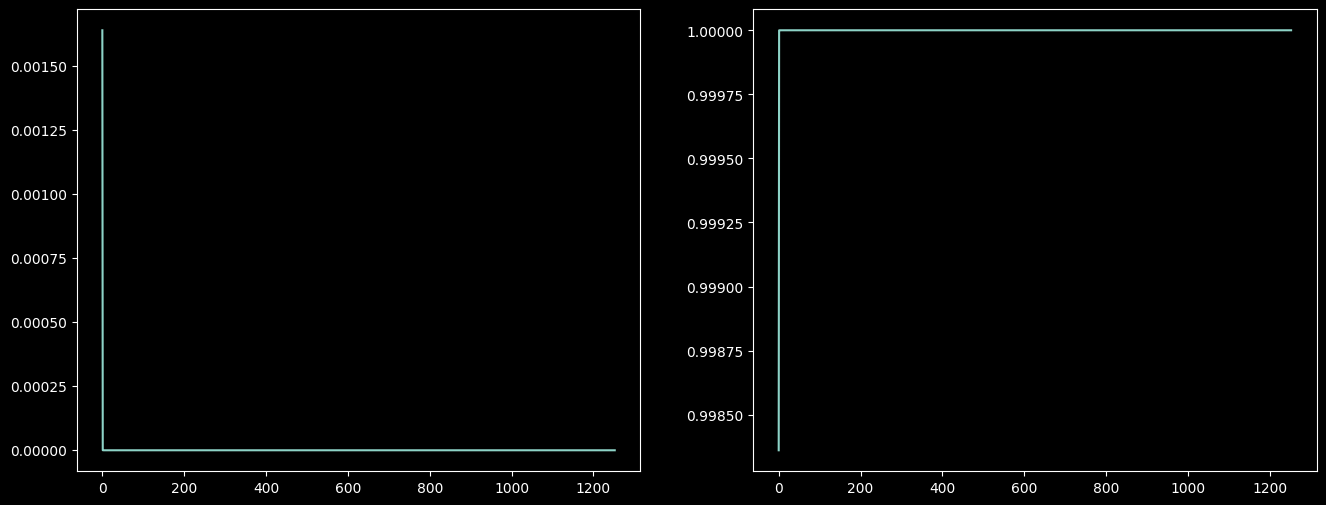


16 3.736678954892598
mu: 0.014047371960333989, sigma: [0.00029665 0.0017585 ], phat0: [[1.20737962e-04 9.99879262e-01]
 [1.80259773e-11 1.00000000e+00]], [0.00163888 0.99836112]
[[1.20737962e-04 9.99879262e-01]
 [1.80259773e-11 1.00000000e+00]]
[[1.20737962e-04 9.99879262e-01]
 [1.80259773e-11 1.00000000e+00]]



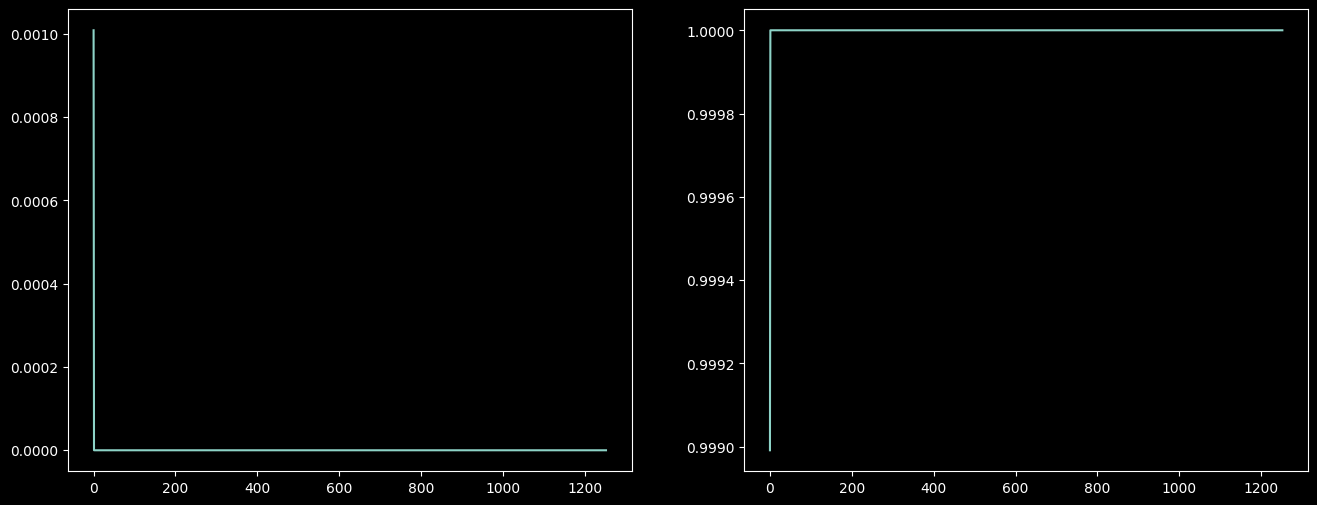


17 1.4671016488593795
mu: 0.014047413953087964, sigma: [0.00029659 0.0017585 ], phat0: [[4.73828816e-05 9.99952617e-01]
 [2.62182340e-12 1.00000000e+00]], [0.0010089 0.9989911]
[[4.73828816e-05 9.99952617e-01]
 [2.62182340e-12 1.00000000e+00]]
[[4.73828816e-05 9.99952617e-01]
 [2.62182340e-12 1.00000000e+00]]



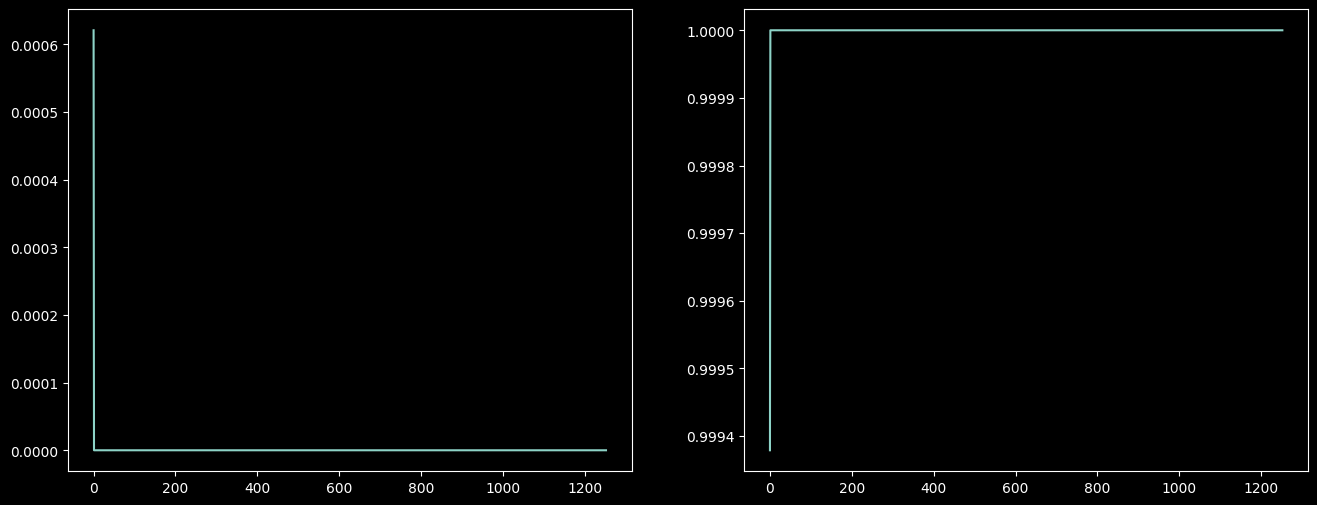


18 0.69973553437693
mu: 0.01404743982384915, sigma: [0.00029656 0.0017585 ], phat0: [[1.85926259e-05 9.99981407e-01]
 [3.81223847e-13 1.00000000e+00]], [6.20929276e-04 9.99379071e-01]
[[1.85926259e-05 9.99981407e-01]
 [3.81223847e-13 1.00000000e+00]]
[[1.85926259e-05 9.99981407e-01]
 [3.81223847e-13 1.00000000e+00]]



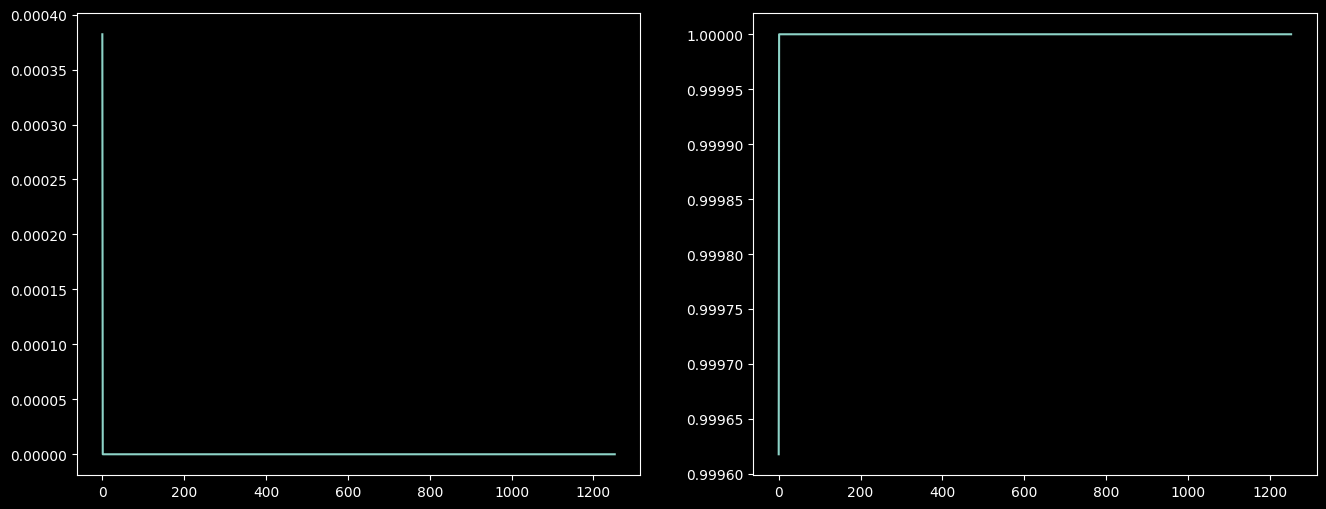


19 0.6625684133333535
mu: 0.014047455753685515, sigma: [0.00029655 0.0017585 ], phat0: [[7.29507015e-06 9.99992705e-01]
 [5.54216931e-14 1.00000000e+00]], [3.82096793e-04 9.99617903e-01]
[[7.29507015e-06 9.99992705e-01]
 [5.54216931e-14 1.00000000e+00]]
[[7.29507015e-06 9.99992705e-01]
 [5.54216931e-14 1.00000000e+00]]



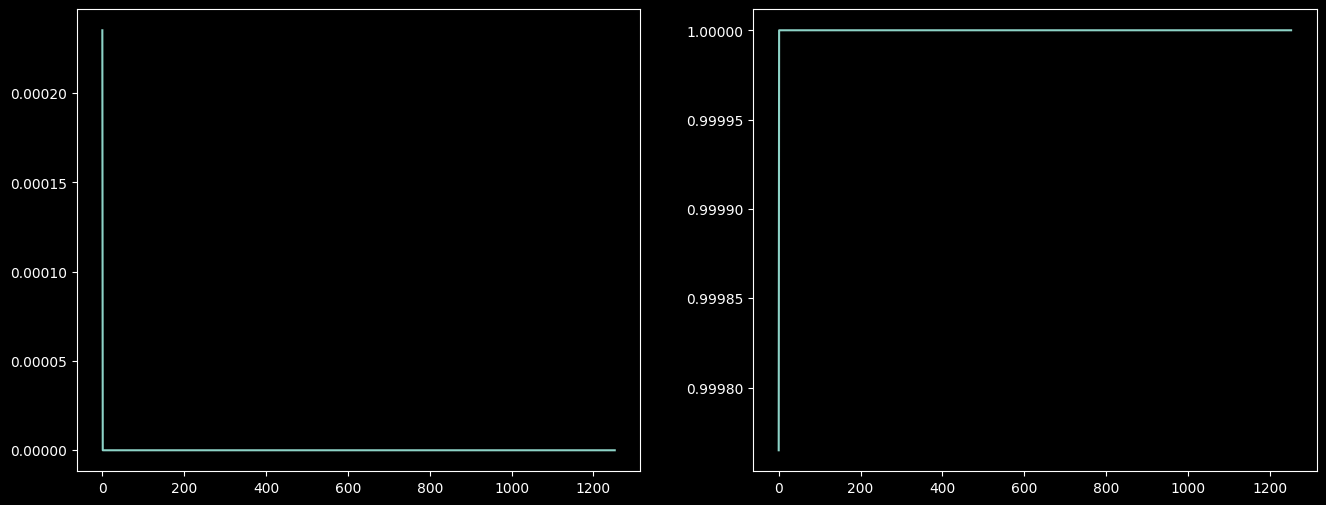


20 0.6097955620496159
mu: 0.01404746555918025, sigma: [0.00029653 0.0017585 ], phat0: [[2.86220956e-06 9.99997138e-01]
 [8.05624876e-15 1.00000000e+00]], [2.35106550e-04 9.99764893e-01]
[[2.86220956e-06 9.99997138e-01]
 [8.05624876e-15 1.00000000e+00]]
[[2.86220956e-06 9.99997138e-01]
 [8.05624876e-15 1.00000000e+00]]



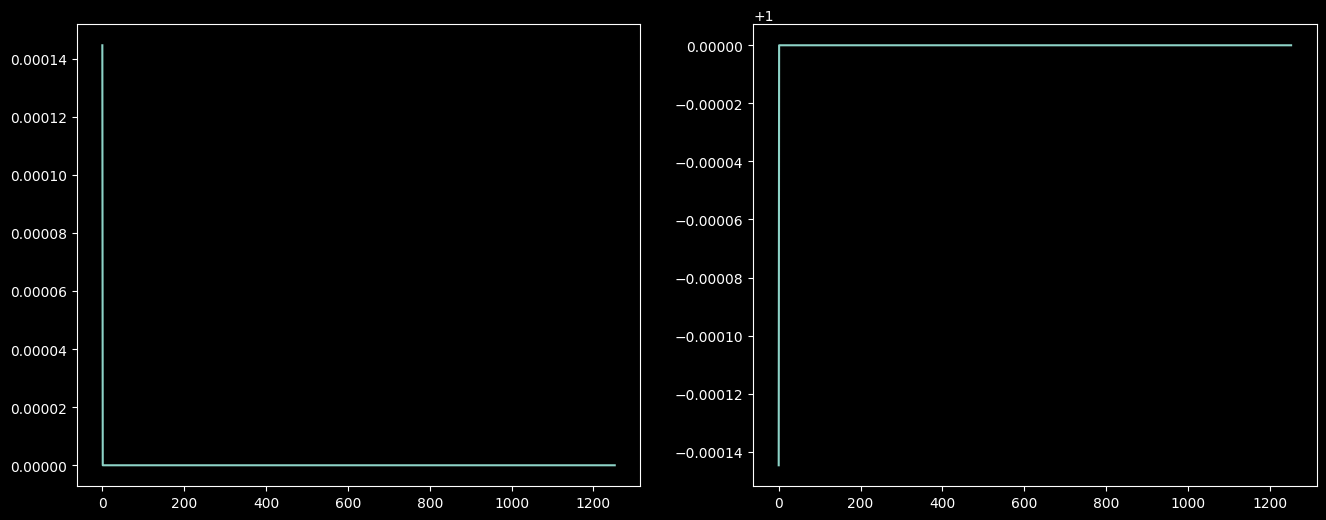


21 0.5398417095115025
mu: 0.014047471593646754, sigma: [0.00029653 0.0017585 ], phat0: [[1.12295876e-06 9.99998877e-01]
 [1.17100161e-15 1.00000000e+00]], [1.44654304e-04 9.99855346e-01]
[[1.12295876e-06 9.99998877e-01]
 [1.17100161e-15 1.00000000e+00]]
[[1.12295876e-06 9.99998877e-01]
 [1.17100161e-15 1.00000000e+00]]



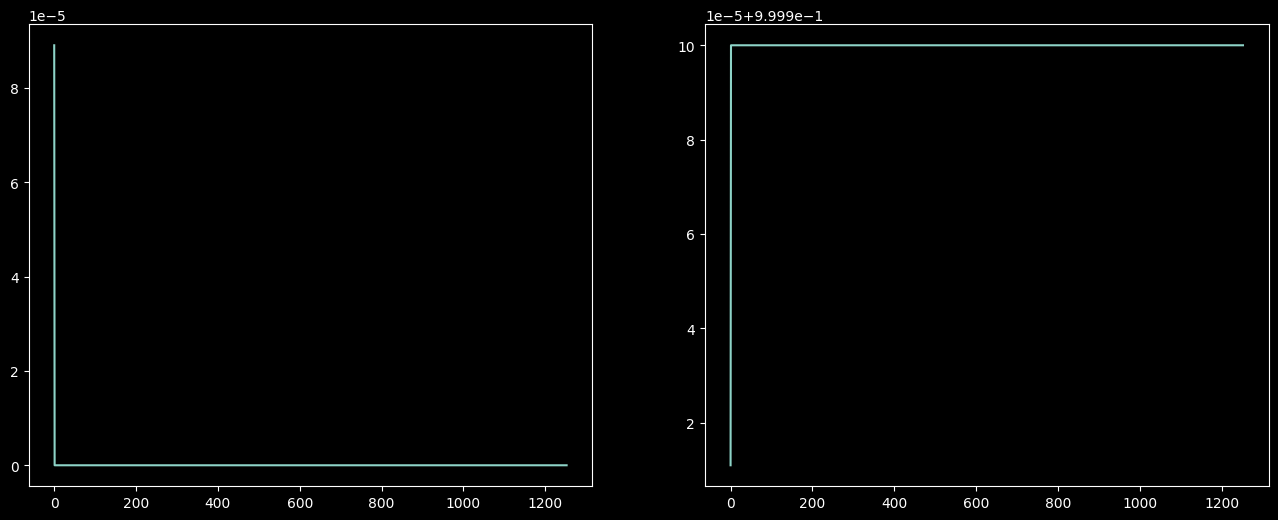


22 0.4549749940126542
mu: 0.014047475306890779, sigma: [0.00029652 0.0017585 ], phat0: [[4.40575747e-07 9.99999559e-01]
 [1.70202015e-16 1.00000000e+00]], [8.89985086e-05 9.99911001e-01]
[[4.40575747e-07 9.99999559e-01]
 [1.70202015e-16 1.00000000e+00]]
[[4.40575747e-07 9.99999559e-01]
 [1.70202015e-16 1.00000000e+00]]



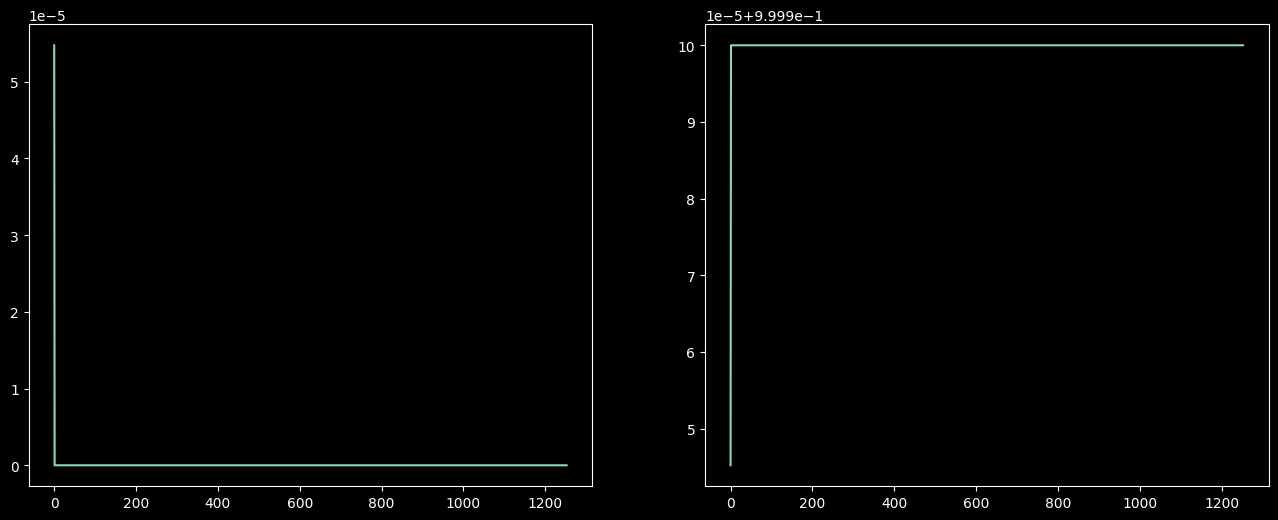


23 0.36236682632225375
mu: 0.01404747759161805, sigma: [0.00029652 0.0017585 ], phat0: [[1.72851849e-07 9.99999827e-01]
 [2.47378086e-17 1.00000000e+00]], [5.47551137e-05 9.99945245e-01]
[[1.72851849e-07 9.99999827e-01]
 [2.47378086e-17 1.00000000e+00]]
[[1.72851849e-07 9.99999827e-01]
 [2.47378086e-17 1.00000000e+00]]



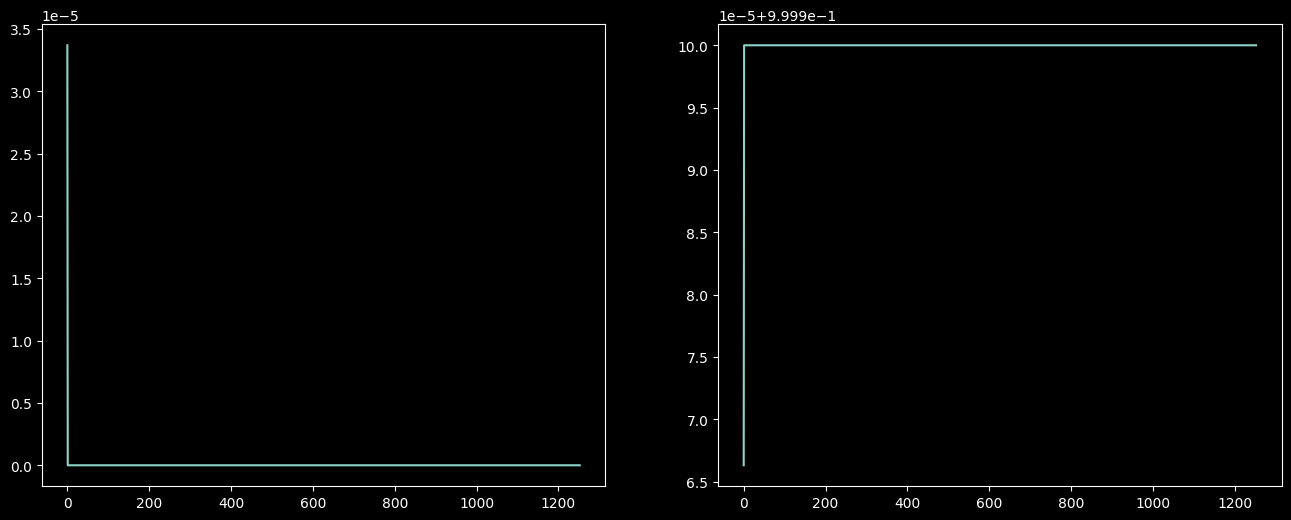


24 0.2722783013246543
mu: 0.014047478997323958, sigma: [0.00029652 0.0017585 ], phat0: [[6.78149524e-08 9.99999932e-01]
 [3.59543298e-18 1.00000000e+00]], [3.36868840e-05 9.99966313e-01]
[[6.78149524e-08 9.99999932e-01]
 [3.59543298e-18 1.00000000e+00]]
[[6.78149524e-08 9.99999932e-01]
 [3.59543298e-18 1.00000000e+00]]



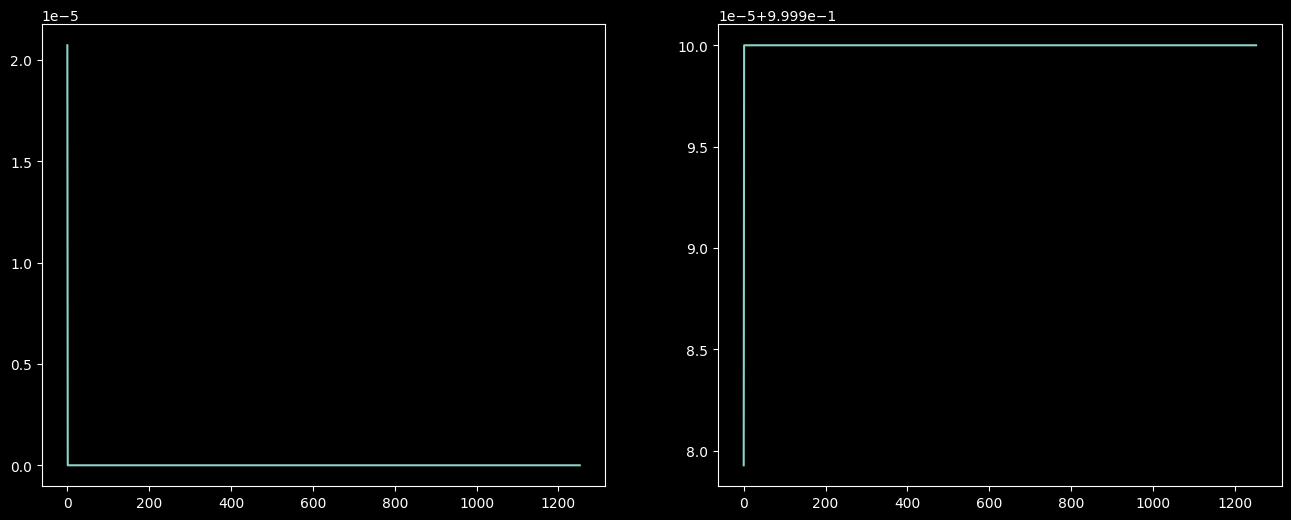


25 0.19391486773078156
mu: 0.014047479862175947, sigma: [0.00029652 0.0017585 ], phat0: [[2.66057604e-08 9.99999973e-01]
 [5.22561177e-19 1.00000000e+00]], [2.07249467e-05 9.99979275e-01]
[[2.66057604e-08 9.99999973e-01]
 [5.22561177e-19 1.00000000e+00]]
[[2.66057604e-08 9.99999973e-01]
 [5.22561177e-19 1.00000000e+00]]



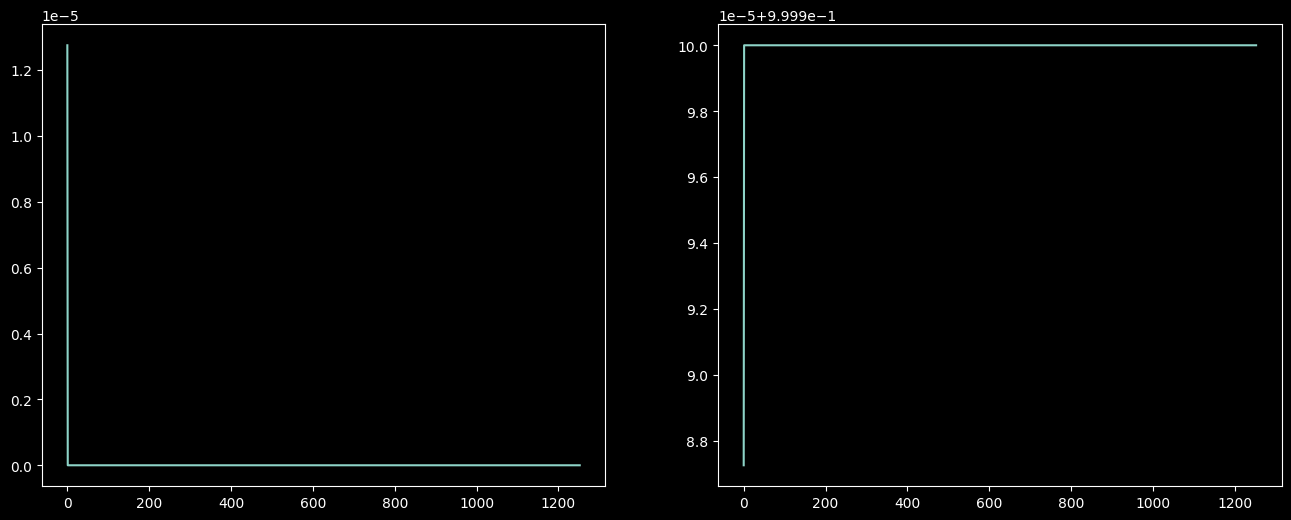


26 0.13211100184830823
mu: 0.014047480394261217, sigma: [0.00029652 0.0017585 ], phat0: [[1.04381888e-08 9.99999990e-01]
 [7.59487462e-20 1.00000000e+00]], [1.27503999e-05 9.99987250e-01]
[[1.04381888e-08 9.99999990e-01]
 [7.59487462e-20 1.00000000e+00]]
[[1.04381888e-08 9.99999990e-01]
 [7.59487462e-20 1.00000000e+00]]



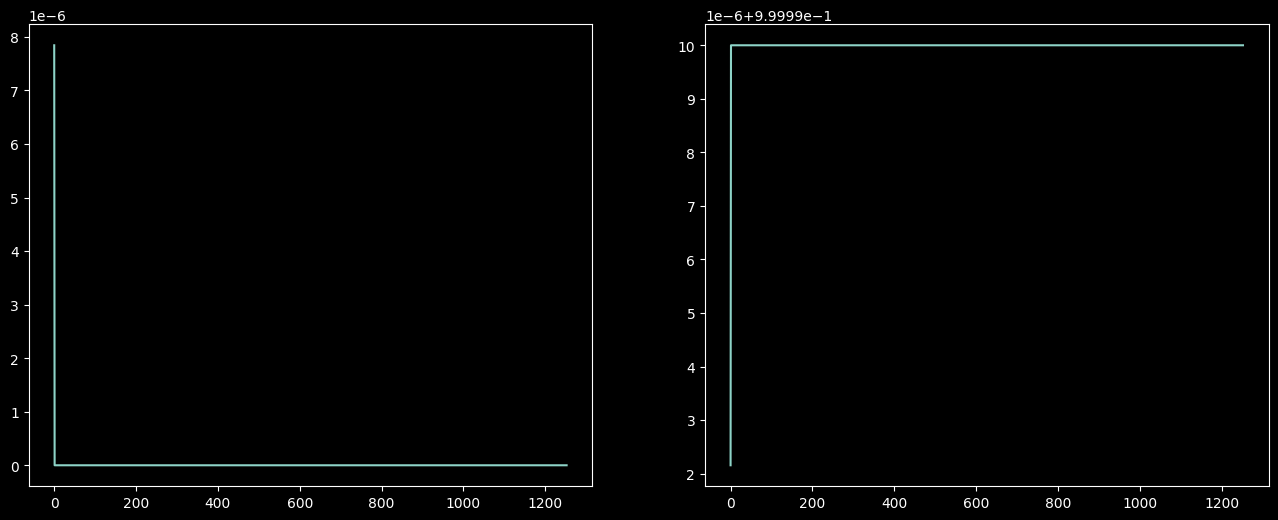


27 0.08702628914671494
mu: 0.014047480721613853, sigma: [0.00029652 0.0017585 ], phat0: [[4.09519100e-09 9.99999996e-01]
 [1.10383092e-20 1.00000000e+00]], [7.84427546e-06 9.99992156e-01]
[[4.09519100e-09 9.99999996e-01]
 [1.10383092e-20 1.00000000e+00]]
[[4.09519100e-09 9.99999996e-01]
 [1.10383092e-20 1.00000000e+00]]



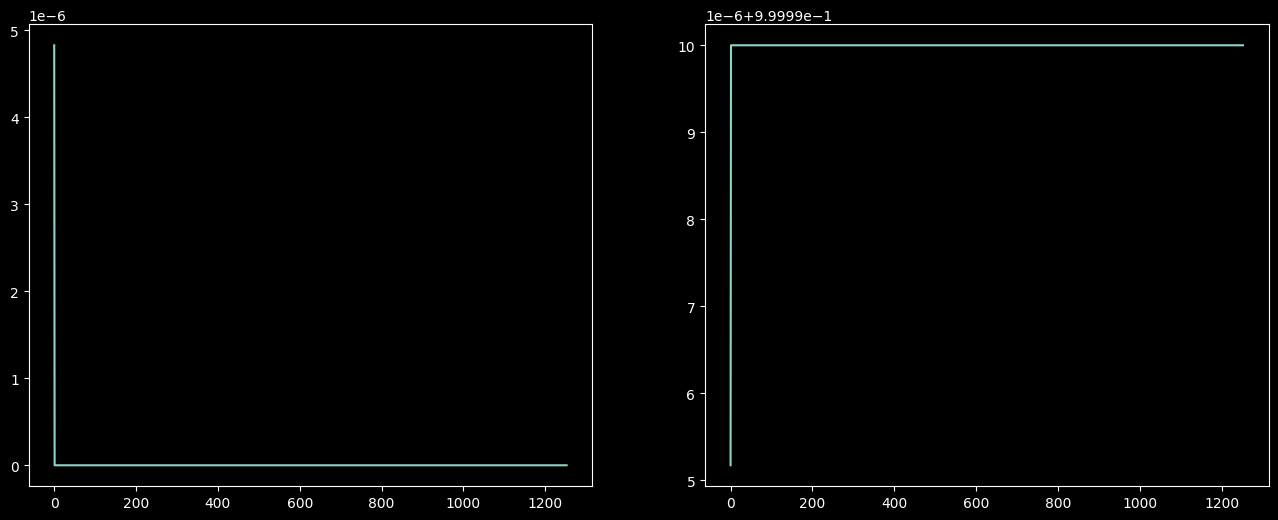


28 0.05597599482993804
mu: 0.014047480923008294, sigma: [0.00029652 0.0017585 ], phat0: [[1.60665600e-09 9.99999998e-01]
 [1.60429253e-21 1.00000000e+00]], [4.82593016e-06 9.99995174e-01]
[[1.60665600e-09 9.99999998e-01]
 [1.60429253e-21 1.00000000e+00]]
[[1.60665600e-09 9.99999998e-01]
 [1.60429253e-21 1.00000000e+00]]



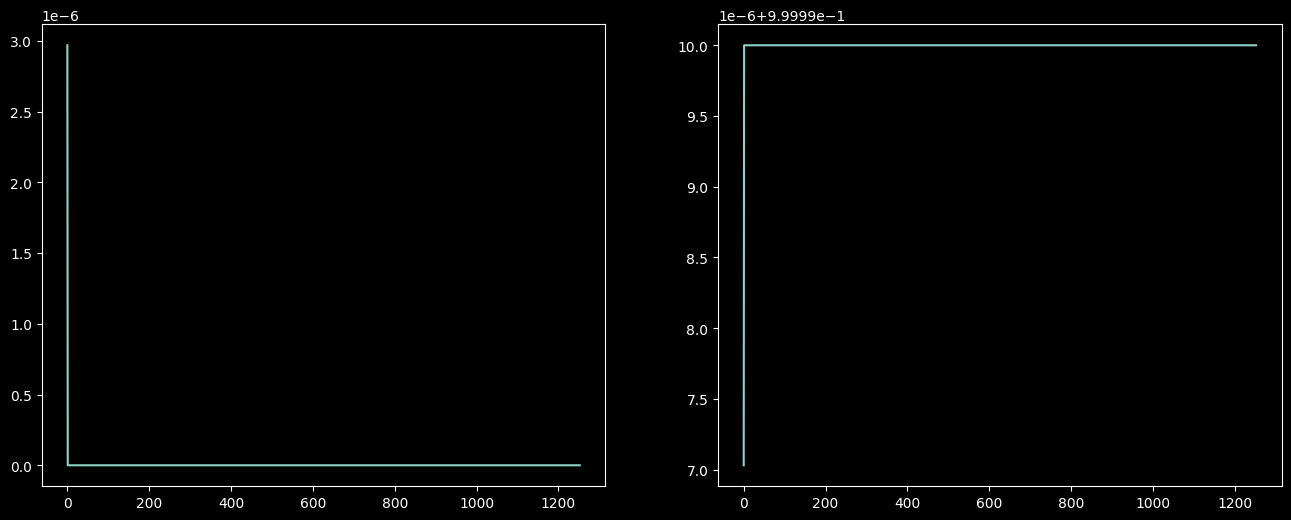


29 0.03542902568675839
mu: 0.014047481046909997, sigma: [0.00029652 0.0017585 ], phat0: [[6.30335062e-10 9.99999999e-01]
 [2.33165341e-22 1.00000000e+00]], [2.96898988e-06 9.99997031e-01]
[[6.30335062e-10 9.99999999e-01]
 [2.33165341e-22 1.00000000e+00]]
[[6.30335062e-10 9.99999999e-01]
 [2.33165341e-22 1.00000000e+00]]



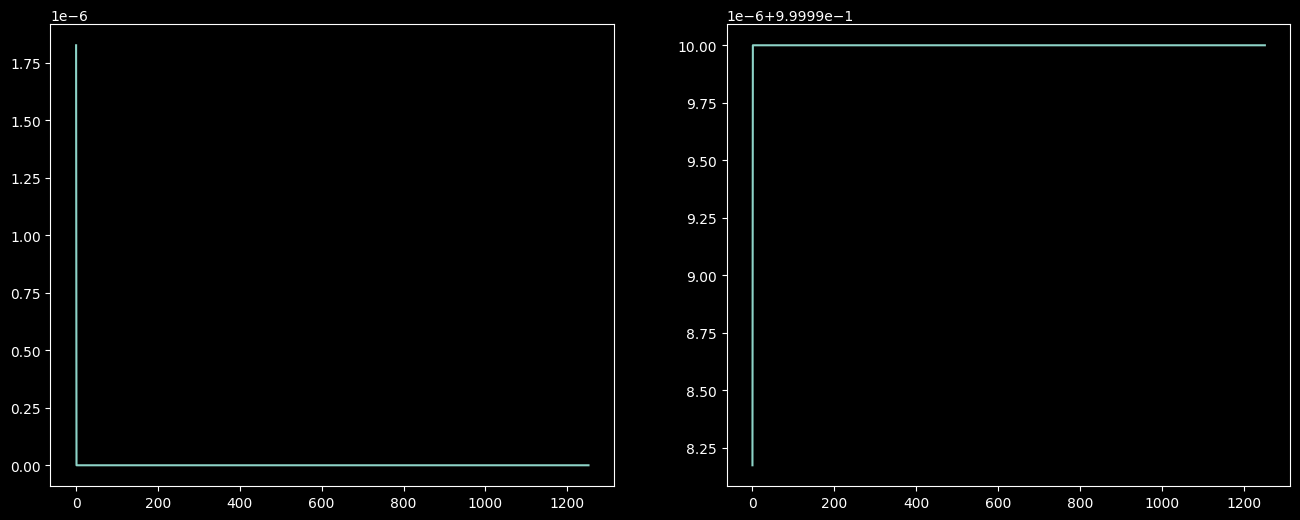


30 0.02218961003059619
mu: 0.014047481123136488, sigma: [0.00029652 0.0017585 ], phat0: [[2.47297614e-10 1.00000000e+00]
 [3.38878545e-23 1.00000000e+00]], [1.82656901e-06 9.99998173e-01]
[[2.47297614e-10 1.00000000e+00]
 [3.38878545e-23 1.00000000e+00]]
[[2.47297614e-10 1.00000000e+00]
 [3.38878545e-23 1.00000000e+00]]



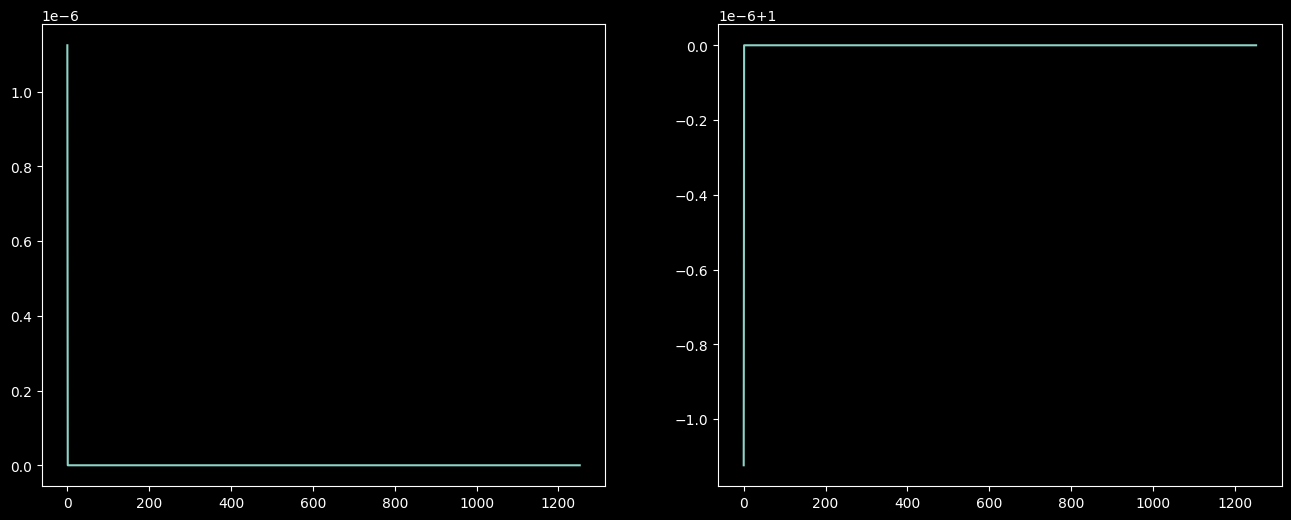


31 0.013804563860315288
mu: 0.014047481170032284, sigma: [0.00029652 0.0017585 ], phat0: [[9.70215754e-11 1.00000000e+00]
 [4.92520072e-24 1.00000000e+00]], [1.12373332e-06 9.99998876e-01]
[[9.70215754e-11 1.00000000e+00]
 [4.92520072e-24 1.00000000e+00]]
[[9.70215754e-11 1.00000000e+00]
 [4.92520072e-24 1.00000000e+00]]



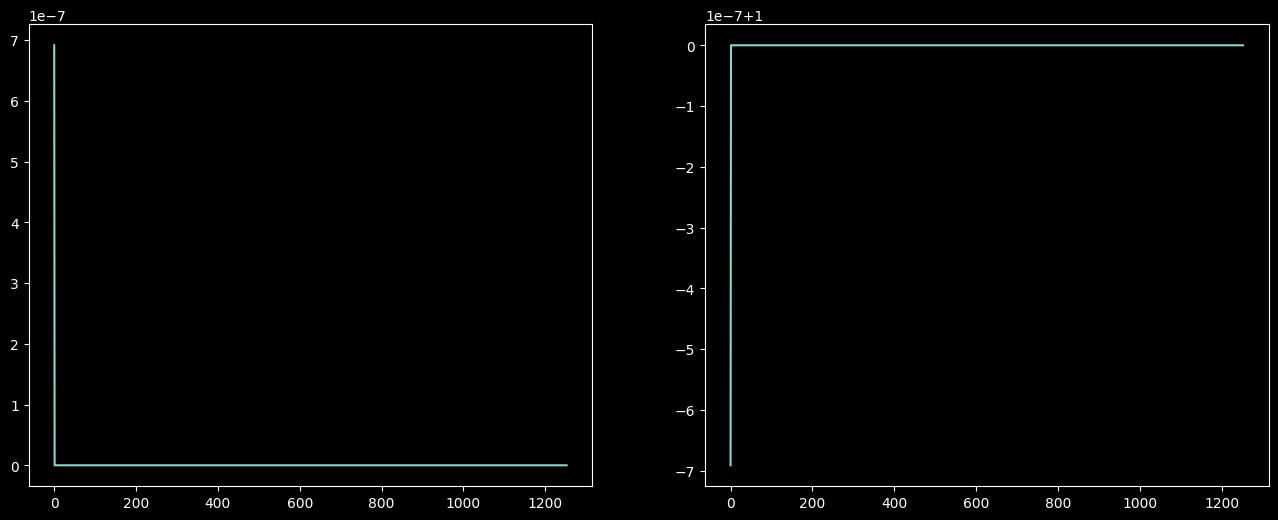


32 0.008551810555725478
mu: 0.014047481198883324, sigma: [0.00029652 0.0017585 ], TransitionMatrix: [[3.80641976e-11 1.00000000e+00]
 [7.15819724e-25 1.00000000e+00]], PiHat: [6.91337818e-07 9.99999309e-01]


In [93]:
for ite in range(0, itemax):
    print(f"mu: {mu_hat0}, sigma: {sigma_hat0}, phat0: {P_hat0}, {pi_hat0}")

    # E-step
    xi_prob_t, xi_prob_t1 = forward_alg(
        pi_hat0, N, T, P_hat0, mu_hat0, sigma_hat0, rubusdData
    )
    xi_prob_T = backward_alg(
        xi_prob_t, xi_prob_t1, N, T, P_hat0, mu_hat0, sigma_hat0, rubusdData
    )

    print("")
    plt.subplot(1, 2, 1)
    plt.plot(xi_prob_T[:, 0])
    plt.subplot(1, 2, 2)
    plt.plot(xi_prob_T[:, 1])
    fig = plt.gcf()
    fig.set_size_inches(16, 6)
    plt.show()
    print("")

    # Compute Pr(s_t+1 = j, s_t = i)
    P_hat_T = np.zeros((N, N, T))
    for tt in range(1, T):
        for ss in range(0, N):
            for ss2 in range(0, N):
                P_hat_T[ss, ss2, tt] = (
                    P_hat0[ss, ss2]
                    * xi_prob_t[tt - 1, ss]
                    * xi_prob_T[tt, ss2]
                    / xi_prob_t1[tt - 1, ss2]
                )
    # M-step
    mu_hat1, sigma_hat1, P_hat1, pi_hat1 = M_step_func(xi_prob_T, sigma_hat0, P_hat_T, N, T, rubusdData)

    diff = np.zeros((4))
    diff[0] = np.sum(np.absolute(mu_hat1 - mu_hat0)) / (np.min(mu_hat0) + itetol * 1e-2)
    diff[1] = np.sum(np.absolute(sigma_hat1 - sigma_hat0)) / (
        np.min(sigma_hat0) + itetol * 1e-2
    )
    diff[2] = np.sum(np.absolute(np.subtract(P_hat1, P_hat0))) / (
        np.min(P_hat0) + itetol * 1e-2
    )
    diff[3] = np.sum(np.absolute(pi_hat1 - pi_hat0)) / (np.min(pi_hat0) + itetol * 1e-2)

    print(ite, np.max(diff))

    if np.max(diff) > itetol:
        mu_hat0, sigma_hat0, P_hat0, pi_hat0 = mu_hat1, sigma_hat1, P_hat1, pi_hat1
    else:        
        print(f"mu: {mu_hat1}, sigma: {sigma_hat1}, TransitionMatrix: {P_hat1}, PiHat: {pi_hat1}")
        break